# Package Imports

In [1]:
# Data Processing
# import importlib
# importlib.reload(vf) 

from project_code import processing_functions as pf, visualization_functions as vf

from datetime import datetime as dt
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from statsmodels.tsa.seasonal import STL


import warnings
warnings.filterwarnings("ignore")

# Data Acquisition 

In this project, we focus our attention on data from a geolocation that corresponds to Toronto, ON, Canada. It will be sourced through Open-Meteo's free Historical Weather API, which does not require a developer key for access. 

## Selections for Data Download 

**General Details:**

- Data Source: https://open-meteo.com/en/docs/historical-weather-api

- API Call: https://archive-api.open-meteo.com/v1/era5?latitude=43.70011&longitude=-79.4163&start_date=1984-01-01&end_date=2023-12-31&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,cloud_cover,wind_speed_10m,sunshine_duration,shortwave_radiation&timezone=America%2FNew_York

Per the documentation, we specify 'era5' in the API call in order to get data from the ERA5 reanalysis model, thereby ensuring data consistency and preventing the capture of unintentional alterations that may have arised from the adoption of different weather model upgrades. 


**Toronto Details:**

- Latitude: 43.70011  
- Longitude: -79.4163  
- Timezone: America/New_York  
- Start Date: 1984-01-01  
- End Date: 2023-12-31  

We will primarily focus our analyses on data between 1994 and 2023; however, we are downloading an additional decade's worth, in case it becomes necessary. 


Although Daily Weather Variables are available for selection, we opt for Hourly Variables instead, so that we can include Cloud Cover information in our analyses. 


**Hourly Weather Variables:**
- Temperature (2 m)
- Relative Humidity (2 m)
- Dew Point (2 m)
- Precipitation (rain + snow)
- Cloud Cover Total
- Wind Speed (10 m)

**Additional Variables:**
- Sunshine Duration

**Solar Radiation Variables:**
- Shortwave Solar Radition GHI

Although this variable will not be used in the experiments, we download it to assess the strength of its relationship to sunshine duration. 

**Settings:**

- Temperature Unit: Celsius  
- Wind Speed Unit: Km/h  
- Precipitation Unit: Millimeter  
- Timeformat: ISO 8601 (e.g. 2022-12-31)  


In [2]:
# Download data from Open Meteo
file_path = '../../data/raw_data/'
file_name = 'era5_data_toronto.json'
api_call = 'https://archive-api.open-meteo.com/v1/era5?latitude=43.70011&longitude=-79.4163&start_date=1984-01-01&end_date=2023-12-31&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,cloud_cover,wind_speed_10m,sunshine_duration,shortwave_radiation&timezone=America%2FNew_York'
pf.download_data(api_call, file_path, file_name)

Data successfully downloaded to ../../data/raw_data/era5_data_toronto.json.


In [3]:
# read in data 
file = f'{file_path}{file_name}'
weather_data = pf.df_from_json(file)
weather_data.name = 'weather_data'

pf.generate_df_summary(weather_data)

Dataframe: weather_data

------ Head: ------


,time,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,cloud_cover,wind_speed_10m,sunshine_duration,shortwave_radiation
0,1984-01-01T00:00,-9.3,75,-13.0,0.0,100,8.0,0.0,0.0
1,1984-01-01T01:00,-9.6,76,-13.0,0.0,85,7.6,0.0,0.0
2,1984-01-01T02:00,-10.1,77,-13.3,0.0,60,6.6,0.0,0.0
3,1984-01-01T03:00,-9.9,79,-12.8,0.0,51,6.0,0.0,0.0
4,1984-01-01T04:00,-10.8,81,-13.4,0.0,32,6.0,0.0,0.0




------ Tail: ------


,time,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,cloud_cover,wind_speed_10m,sunshine_duration,shortwave_radiation
350635,2023-12-31T19:00,0.4,82,-2.3,0.1,100,12.7,0.0,0.0
350636,2023-12-31T20:00,0.3,84,-2.1,0.3,100,11.9,0.0,0.0
350637,2023-12-31T21:00,0.2,88,-1.5,0.5,100,13.6,0.0,0.0
350638,2023-12-31T22:00,0.2,89,-1.5,0.4,100,13.0,0.0,0.0
350639,2023-12-31T23:00,0.1,89,-1.5,0.3,100,13.2,0.0,0.0




------ Column Summaries: ------


,count,unique,top,freq
time,350640,350640,1984-01-01T00:00,1


,count,mean,std,min,25%,50%,75%,max
temperature_2m,350640.0,8.385759,10.559070,-27.1,0.4,8.4,17.4,34.2
relative_humidity_2m,350640.0,71.907723,14.841568,18.0,61.0,73.0,84.0,100.0
dew_point_2m,350640.0,3.302916,10.535977,-31.7,-4.1,3.6,12.2,24.9
precipitation,350640.0,0.092773,0.395930,0.0,0.0,0.0,0.0,19.4
cloud_cover,350640.0,49.286633,38.425978,0.0,11.0,43.0,90.0,100.0
wind_speed_10m,350640.0,13.569120,6.646731,0.0,8.6,12.6,17.7,50.8
sunshine_duration,350640.0,1238.381057,1649.720954,0.0,0.0,0.0,3600.0,3600.0
shortwave_radiation,350640.0,162.148574,239.368387,0.0,0.0,7.0,271.0,1008.0




------ Counts: ------

Rows: 350,640
Columns: 9
Duplicate Rows = 0 | % of Total Rows = 0.0%


------ Info: ------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350640 entries, 0 to 350639
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   time                  350640 non-null  object 
 1   temperature_2m        350640 non-null  float64
 2   relative_humidity_2m  350640 non-null  int64  
 3   dew_point_2m          350640 non-null  float64
 4   precipitation         350640 non-null  float64
 5   cloud_cover           350640 non-null  int64  
 6   wind_speed_10m        350640 non-null  float64
 7   sunshine_duration     350640 non-null  float64
 8   shortwave_radiation   350640 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 24.1+ MB


None



------ Missing Data Percentage: ------


time                    0.0
temperature_2m          0.0
relative_humidity_2m    0.0
dew_point_2m            0.0
precipitation           0.0
cloud_cover             0.0
wind_speed_10m          0.0
sunshine_duration       0.0
shortwave_radiation     0.0
dtype: float64

There is no missing data, nor do there appear to be any immediately obvious outliers. However, we will formally assess the latter later. 

In [4]:
# rename columns 
mapper = {
    'temperature_2m' : 'temp',
    'relative_humidity_2m' : 'humidity',
    'dew_point_2m' : 'dew_point',
    'precipitation': 'precipitation',
    'cloud_cover' : 'cloud_cover',
    'wind_speed_10m' : 'wind_speed',
    'sunshine_duration' : 'sunshine_s'
}

weather_data.rename(columns=mapper, inplace=True)
weather_data['time'] = pd.to_datetime(weather_data['time'])
df_daily = pf.daily_aggregations(weather_data)

# subset to only include data from 1995
df_daily_subset = df_daily['1995':]
df_daily_subset.name = 'df_daily_subset'
df_daily_subset['temp_range'] = df_daily_subset['max_temp'] - df_daily_subset['min_temp']

print(f'The aggregated daily dataset has {df_daily_subset.shape[0]} rows and {df_daily_subset.shape[1]} columns.')

The aggregated daily dataset has 10592 rows and 19 columns.


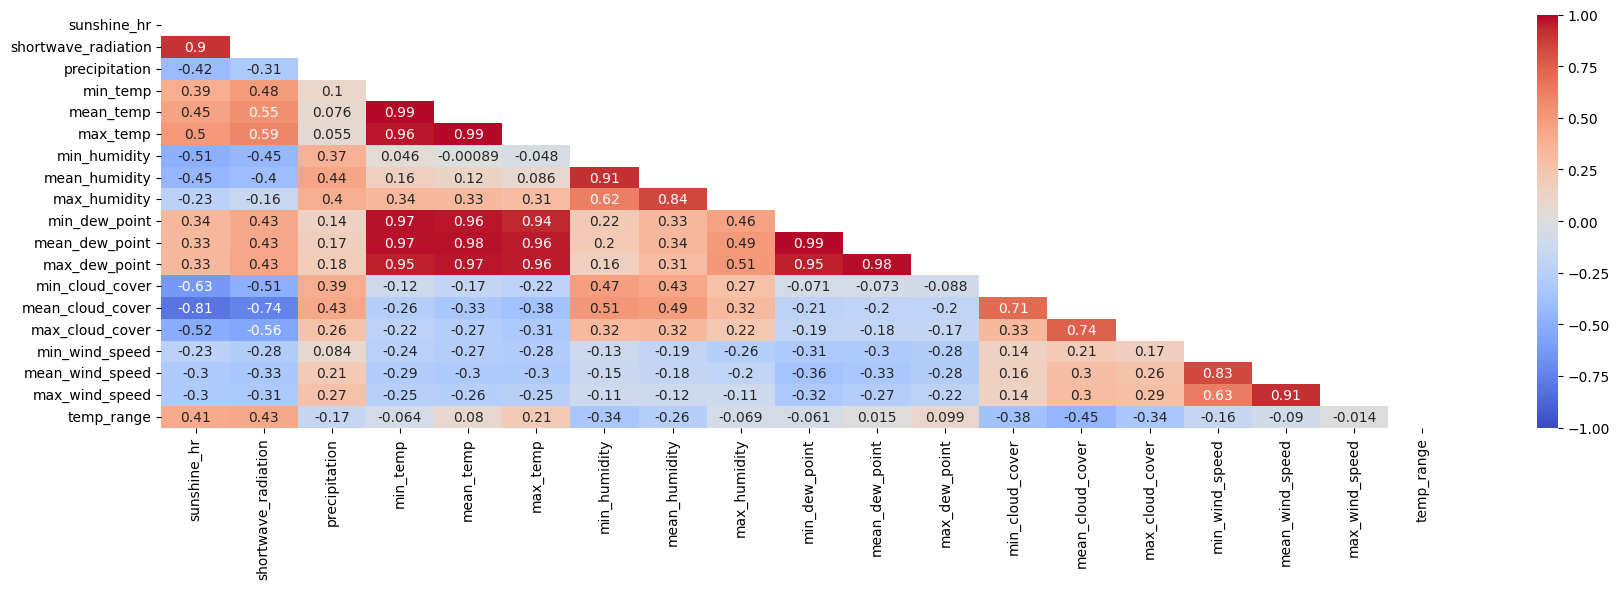

In [5]:
vf.correlation_matrix(df_daily_subset, name='correlation_all')

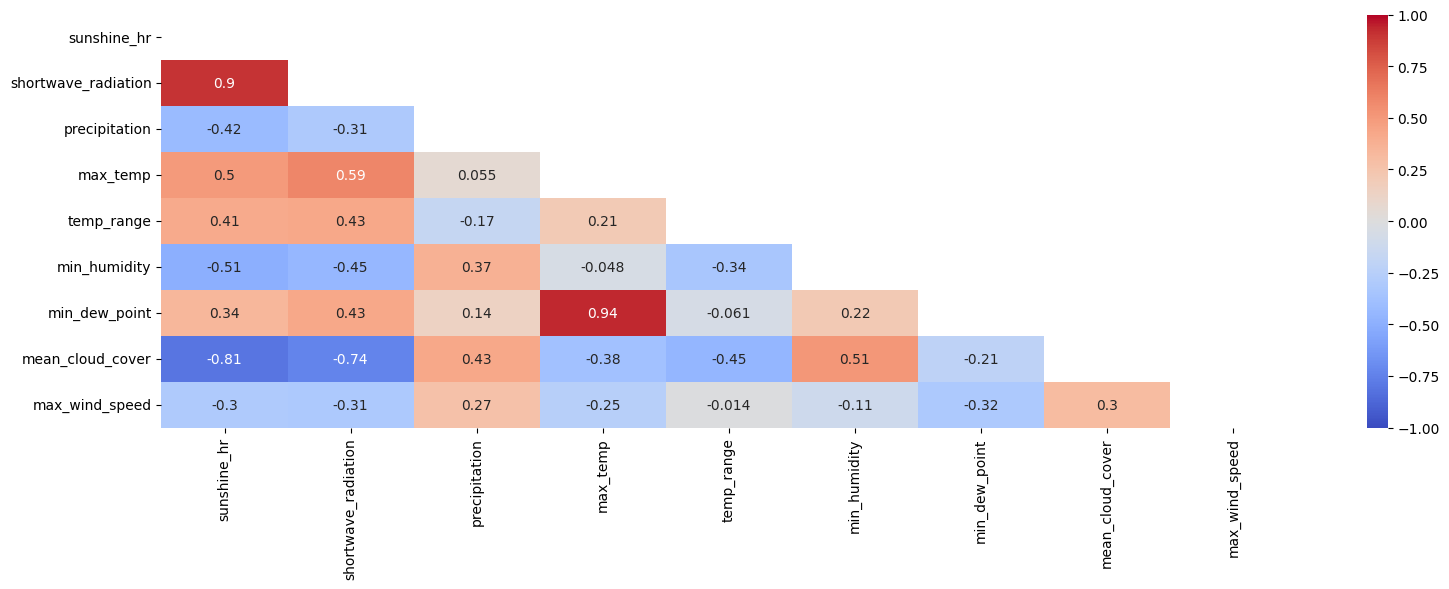

In [6]:
# a pared down correlation matrix plot based on the strongest variables within categories
top_corr_columns = ['sunshine_hr', 'shortwave_radiation', 'precipitation','max_temp', 'temp_range', 
                    'min_humidity', 'min_dew_point', 'mean_cloud_cover', 'max_wind_speed']

df_daily_subset = df_daily_subset.loc[:, top_corr_columns]
df_daily_subset.name = 'df_daily_subset'

vf.correlation_matrix(df_daily_subset, figsize=(16,6), name='correlation_matrix_subset')

As expected, we can see that there is a very strong positive correlation (+0.9) between shortwave radiation and sunshine duration. There is also a very strong positive correlation between the maximum temperature and the minimum dew point (0.94), so we will drop one of the two in order to avoid potential issues related to mulicollinearity. Because maximum temperature is more strongly correlated with sunshine duration (0.5 vs. 0.34), we will drop minimum dew point. We will also drop shortwave_radiation, because its inclusion only served to demonstrate its strong relationship to sunshine duration. The goal is to be able to use our chosen model to predict sunshine duration, which can then feed into efforts to predict shortwave radiation where its measurements are not readily available.  

We are keeping both the *max_temp* and the *temp_range* fields because we hypothesize that the latter might add some beneficial information to our models. Overall, and excluding *shortwave_radiation* which we will be dropping before proceeding further in the analysis, the four fields most strongly correlated with sunshine duration are *mean_cloud_cover* (-0.81), *min_humidity* (-0.51), *max_temp* (0.5), and *precipitation* (0.42).

In [7]:
df_daily_subset.drop(['min_dew_point', 'shortwave_radiation'], axis=1, inplace=True)

df_daily_subset.head()

,sunshine_hr,precipitation,max_temp,temp_range,min_humidity,mean_cloud_cover,max_wind_speed
date,,,,,,,
1995-01-01,1.966,3.7,2.7,3.0,78,97.500,12.6
1995-01-02,7.805,0.0,-0.7,4.3,54,50.417,35.6
1995-01-03,4.189,0.0,-1.9,4.5,47,37.875,27.3
1995-01-04,7.547,0.0,-6.8,3.6,40,46.875,32.4
1995-01-05,7.944,0.0,-5.7,5.3,46,32.250,33.9


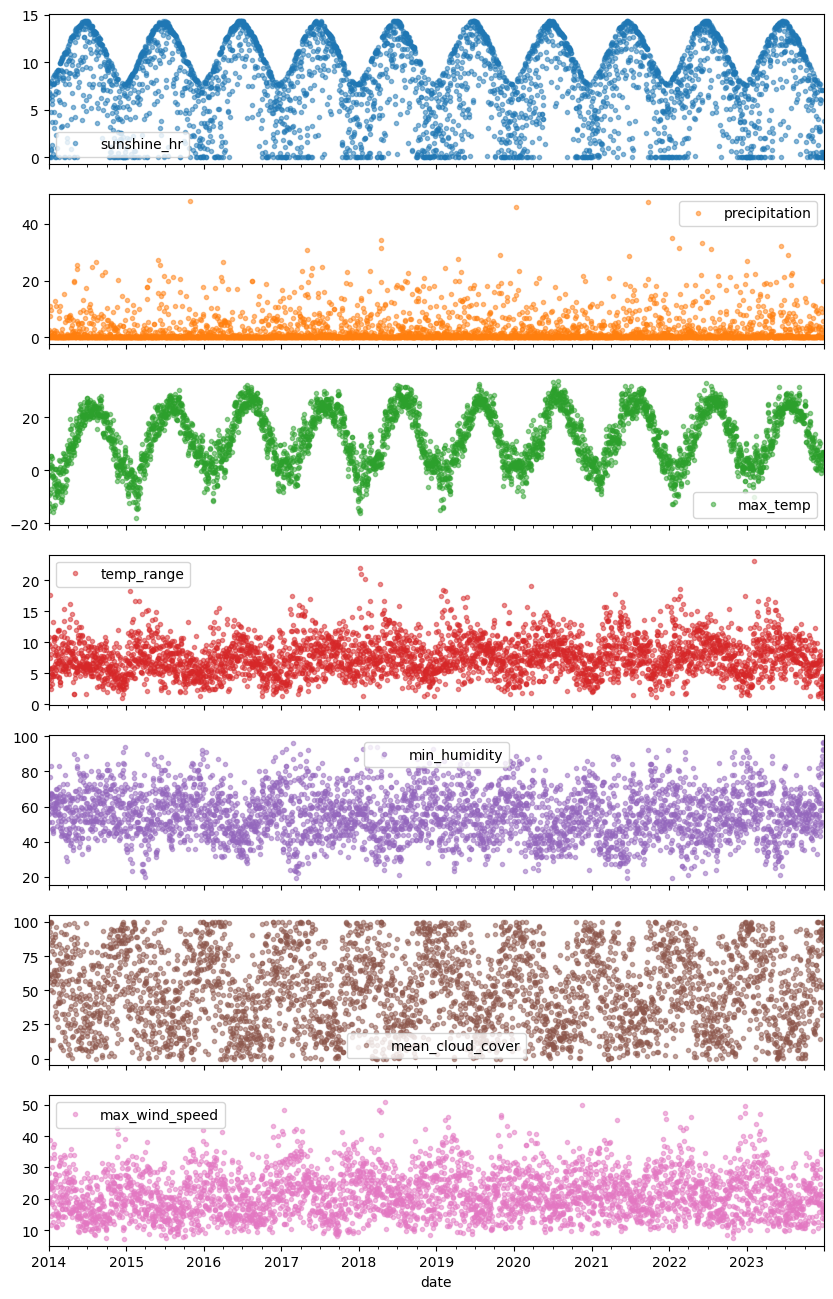

In [8]:
# sns.set_style("whitegrid", {'grid.linestyle': ':'})
df_daily_subset.loc['2014':'2023'].plot(marker='.', alpha=0.5,
                                               linestyle='None',
                                                figsize=(10, 16),
                                                subplots=True)
plt.show()

We can see that Sunshine Duration and the Maximum Temperature in particular exhibit a very clear annual seasonal pattern. A less pronounced version of this trend can be observed in the case of Mean Cloud Cover. Precipitation, on the other hand, does not appear to display any observable trend. 

Let us zero in on Sunshine Duration via decomposition:

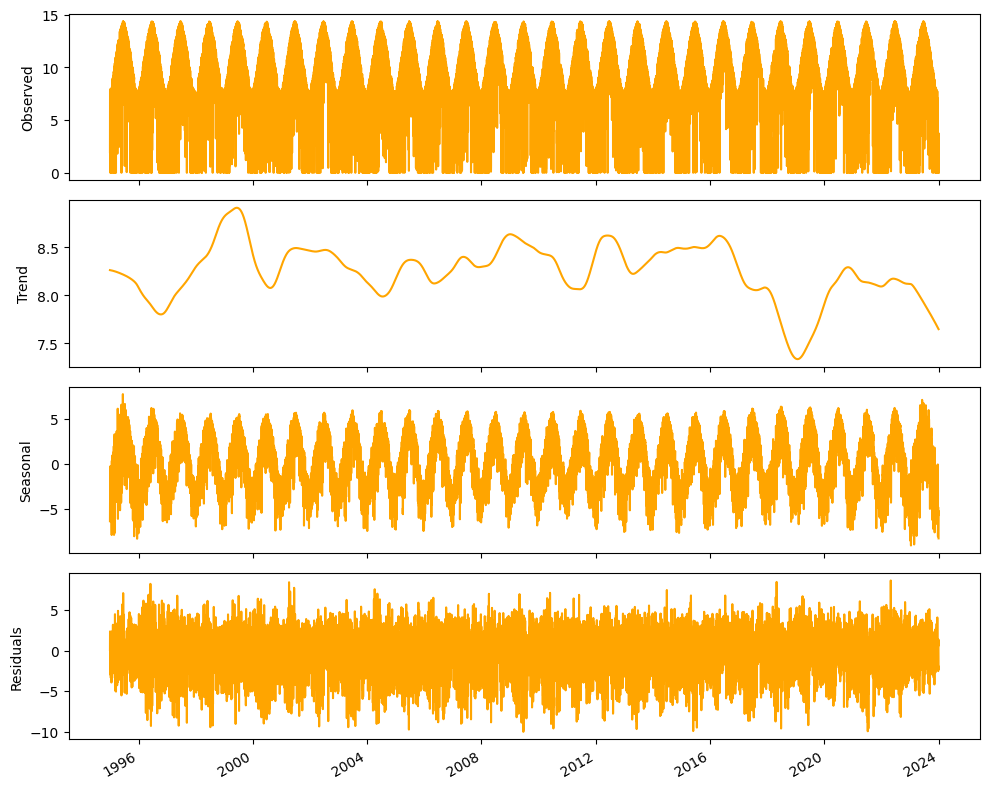

In [9]:
vf.plot_seasonal_decomposition(df_daily_subset, 'sunshine_hr', period=365, color='orange')

Let us compare that to Mean Cloud Cover:

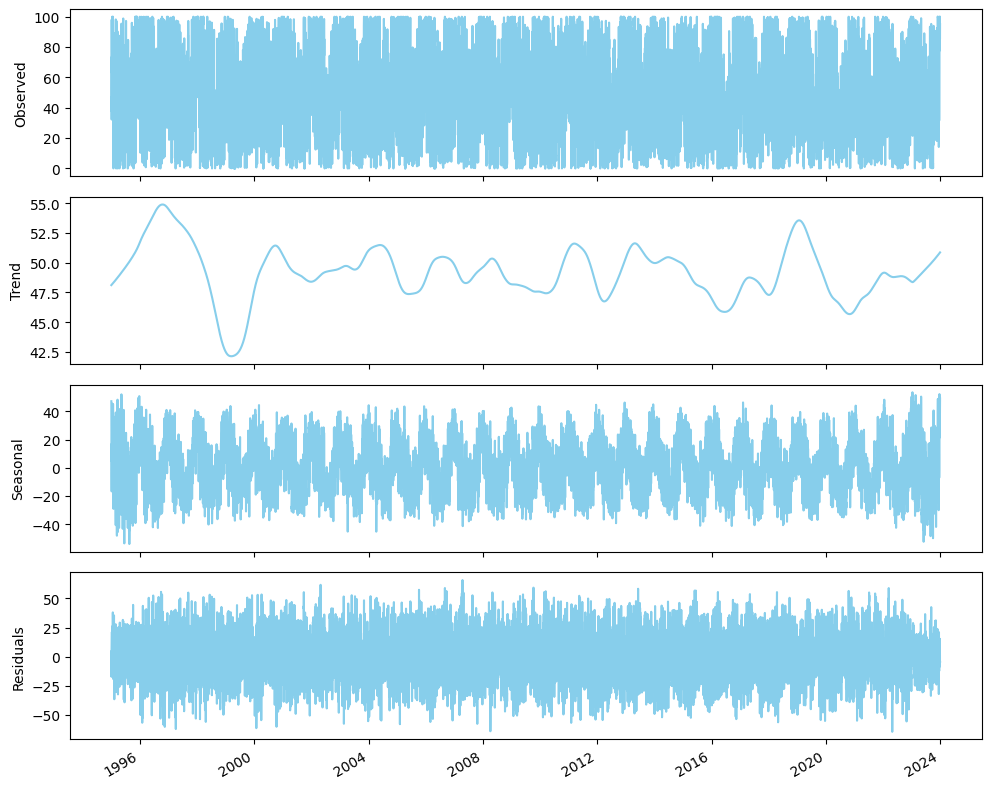

In [10]:
vf.plot_seasonal_decomposition(df_daily_subset, 'mean_cloud_cover', period=365, color='skyblue')

In looking at the Trend charts, we note that dips in average cloud cover correspond with increases in sunshine duration, and vice versa. This makes sense, as there tends to be lower cloud coverage on sunny days. 

We now turn our attention to the distribution of values in our main field of interest:

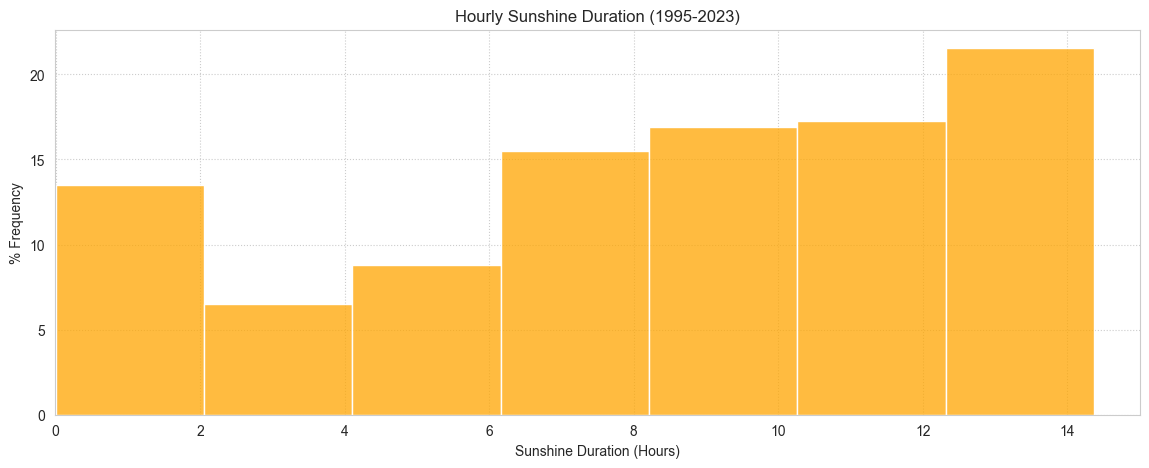

In [12]:
sns.set_style("whitegrid", {'grid.linestyle': ':'})
plt.figure(figsize=(14,5))
sns.histplot(df_daily_subset, x='sunshine_hr', bins=7, color='orange',
            stat='percent')
plt.title('Hourly Sunshine Duration (1995-2023)')
plt.xlabel('Sunshine Duration (Hours)')
plt.ylabel('% Frequency')
plt.xlim(-0.01, 15)
plt.grid(True)
plt.savefig('hourly_sunshine_duration.png')
plt.show()

Approximately 22% of the year sees between ~ 12.3 and ~ 14.3 hours of sun, while almost a third of the year (~28%) sees ~6.2 hours or fewer. ~13.5 % of the year gets between 0 and 2 hours of sun. 

For the next part of the analysis, we will create some time-based variables.

In [13]:
# df_daily_subset['date'] = df_daily_subset.index
df_daily_subset['year'] = df_daily_subset.index.year
df_daily_subset['month'] = df_daily_subset.index.month
df_daily_subset['month_day'] = (df_daily_subset.index.month * 100) + df_daily_subset.index.day
df_daily_subset['season_str'] = df_daily_subset['month_day'].apply(pf.get_season, data_type='string')
df_daily_subset['season_int'] = df_daily_subset['month_day'].apply(pf.get_season, data_type='int')
df_daily_subset.drop('month_day', axis=1, inplace=True)
df_daily_subset['day_of_year'] = df_daily_subset.index.day_of_year

df_daily_subset.head(3)

,sunshine_hr,precipitation,max_temp,temp_range,min_humidity,mean_cloud_cover,max_wind_speed,year,month,season_str,season_int,day_of_year
date,,,,,,,,,,,,
1995-01-01,1.966,3.7,2.7,3.0,78,97.500,12.6,1995,1,Winter,4,1
1995-01-02,7.805,0.0,-0.7,4.3,54,50.417,35.6,1995,1,Winter,4,2
1995-01-03,4.189,0.0,-1.9,4.5,47,37.875,27.3,1995,1,Winter,4,3


We can now generate some monthly and annual stats:

In [15]:
month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
               'September', 'October', 'November', 'December']

month_label_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
               'Sep', 'Oct', 'Nov', 'Dec']

annual_monthly_means = df_daily_subset.loc[:, ['sunshine_hr','year', 'month']].groupby(['year','month']).mean().reset_index()
display(annual_monthly_means.head())

monthly_subset_means = {}

for idx, month in enumerate(month_labels):
    monthly_data = annual_monthly_means[annual_monthly_means['month'] == idx+1]
    monthly_data['3yr_rolling_avg'] = monthly_data.sunshine_hr.rolling(3).mean()
    monthly_subset_means[month] = monthly_data

monthly_subset_means['January'].head()

,year,month,sunshine_hr
0,1995,1,4.037097
1,1995,2,7.016214
2,1995,3,8.842742
3,1995,4,8.549833
4,1995,5,10.343452


,year,month,sunshine_hr,3yr_rolling_avg
0,1995,1,4.037097,NaN
12,1996,1,4.944226,NaN
24,1997,1,4.539258,4.506860
36,1998,1,3.341774,4.275086
48,1999,1,4.234742,4.038591


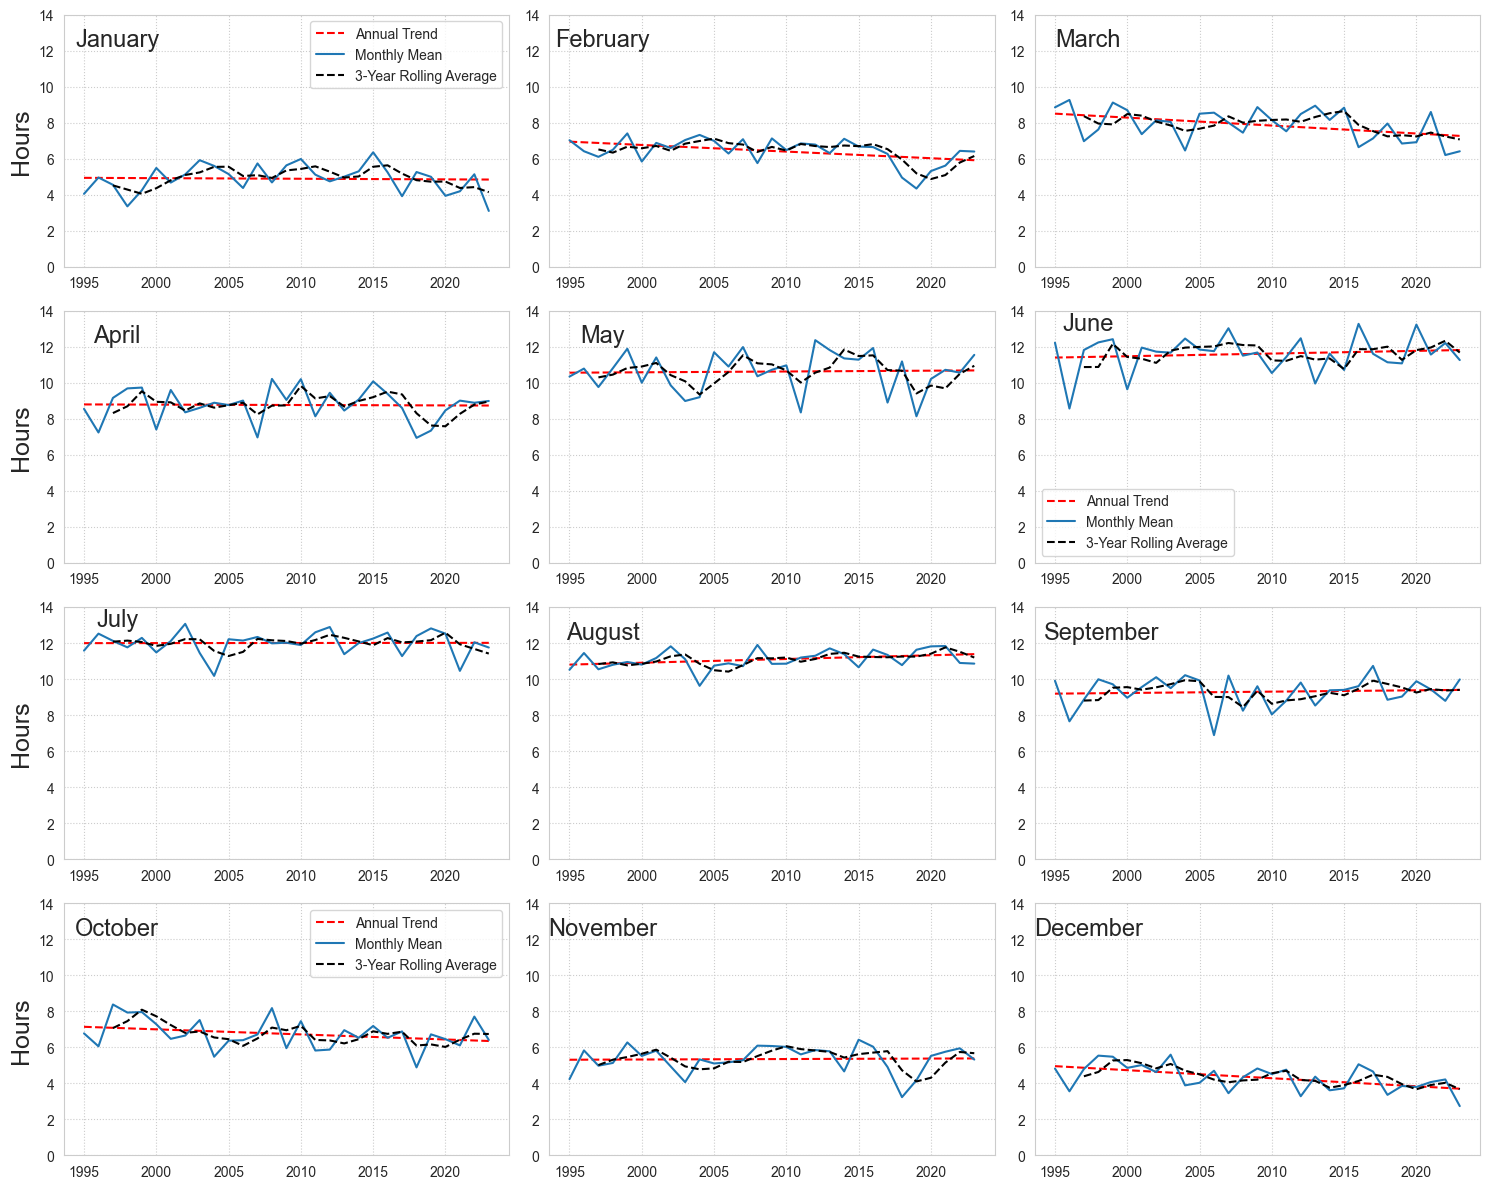

In [16]:
vf.plot_monthly_charts(monthly_data=monthly_subset_means, figsize=(15, 12), column='sunshine_hr', name='monthly_sunshine_trends')

Overall, the annual trend appears to be relatively flat for half of the months. We observe a downward trend in February, March, October, and December, and a slight upward trend in June and August. As expected, sunshine duration is higher in the Spring and Summer months, and particularly in July and June. 

We repeat the above exercise with seasonal data:

In [17]:
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

annual_seasonal_means = df_daily_subset.loc[:, ['sunshine_hr', 'precipitation', 'year', 'season_str']]\
                                                .groupby(['year','season_str']).mean().reset_index()
display(annual_seasonal_means.head())
seasonal_subset_means = {}

for idx, season in enumerate(seasons):
    seasonal_data = annual_seasonal_means[annual_seasonal_means['season_str'] == season]
    seasonal_data['3yr_rolling_avg'] = seasonal_data.sunshine_hr.rolling(3).mean()
    seasonal_subset_means[season] = seasonal_data
    

,year,season_str,sunshine_hr,precipitation
0,1995,Fall,5.795562,3.330337
1,1995,Spring,10.094707,1.993478
2,1995,Summer,10.910628,1.790426
3,1995,Winter,5.972389,1.784444
4,1996,Fall,5.525169,3.296629


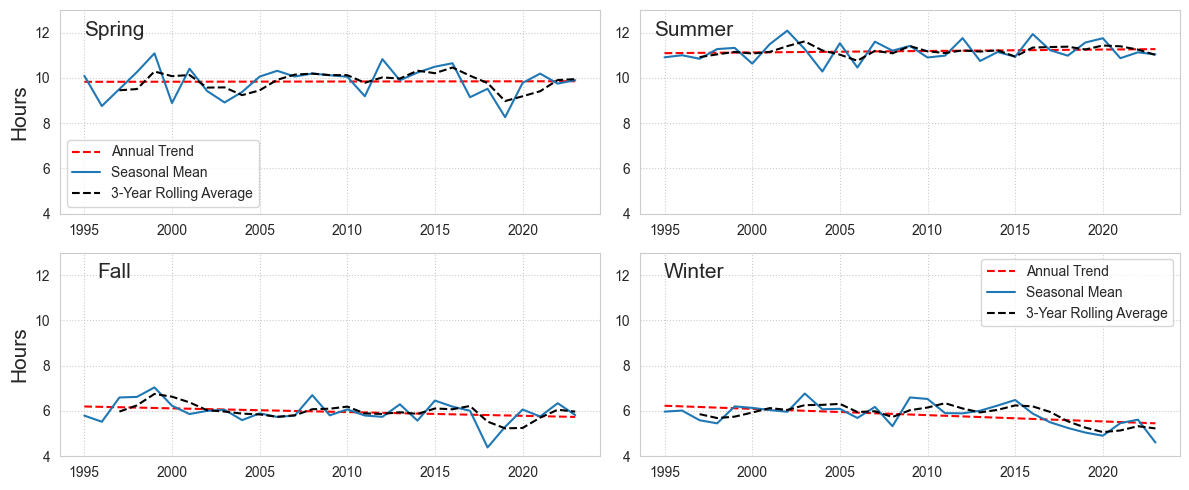

In [18]:
vf.plot_seasonal_charts(monthly_data=seasonal_subset_means, figsize=(12, 5), 
                        column='sunshine_hr', name='seasonal_sunshine_trends')

The Spring and Summer trends appear to be relatively flat, albeit ever so slightly positive in the case of Summer, while we observe a slight downward trend in the case of Fall and Winter, with the latter's being more pronounced. 

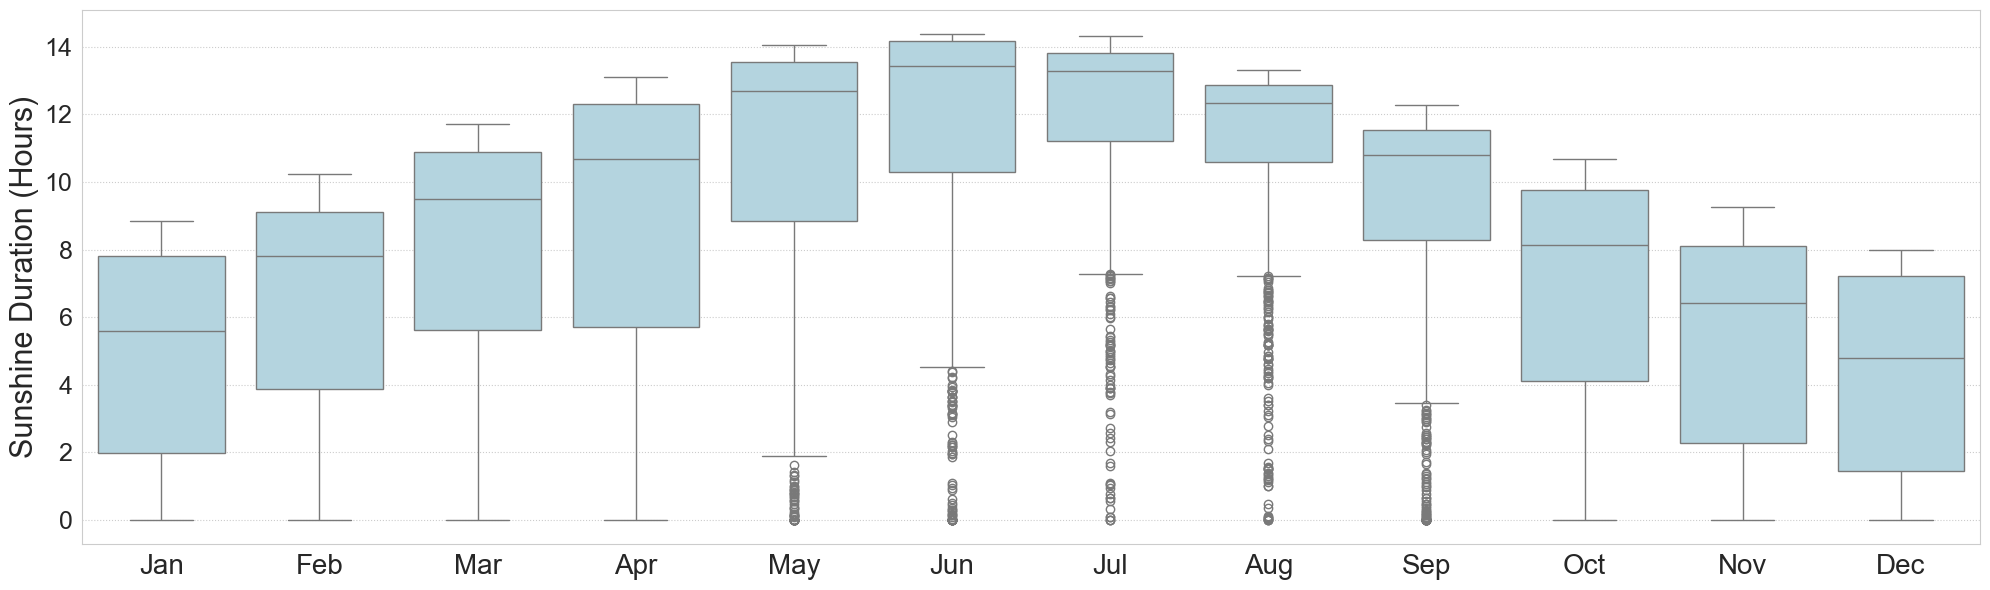

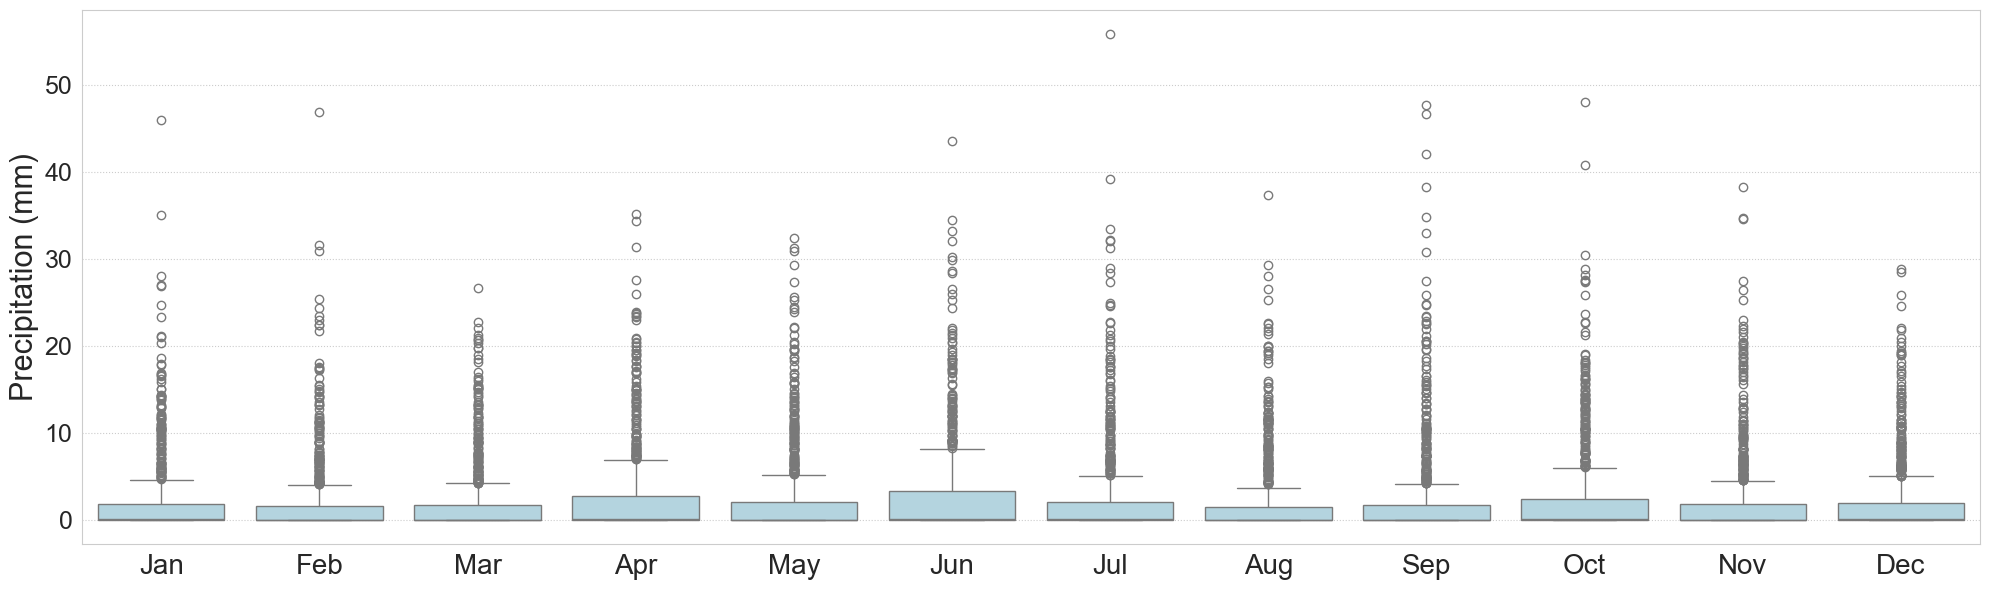

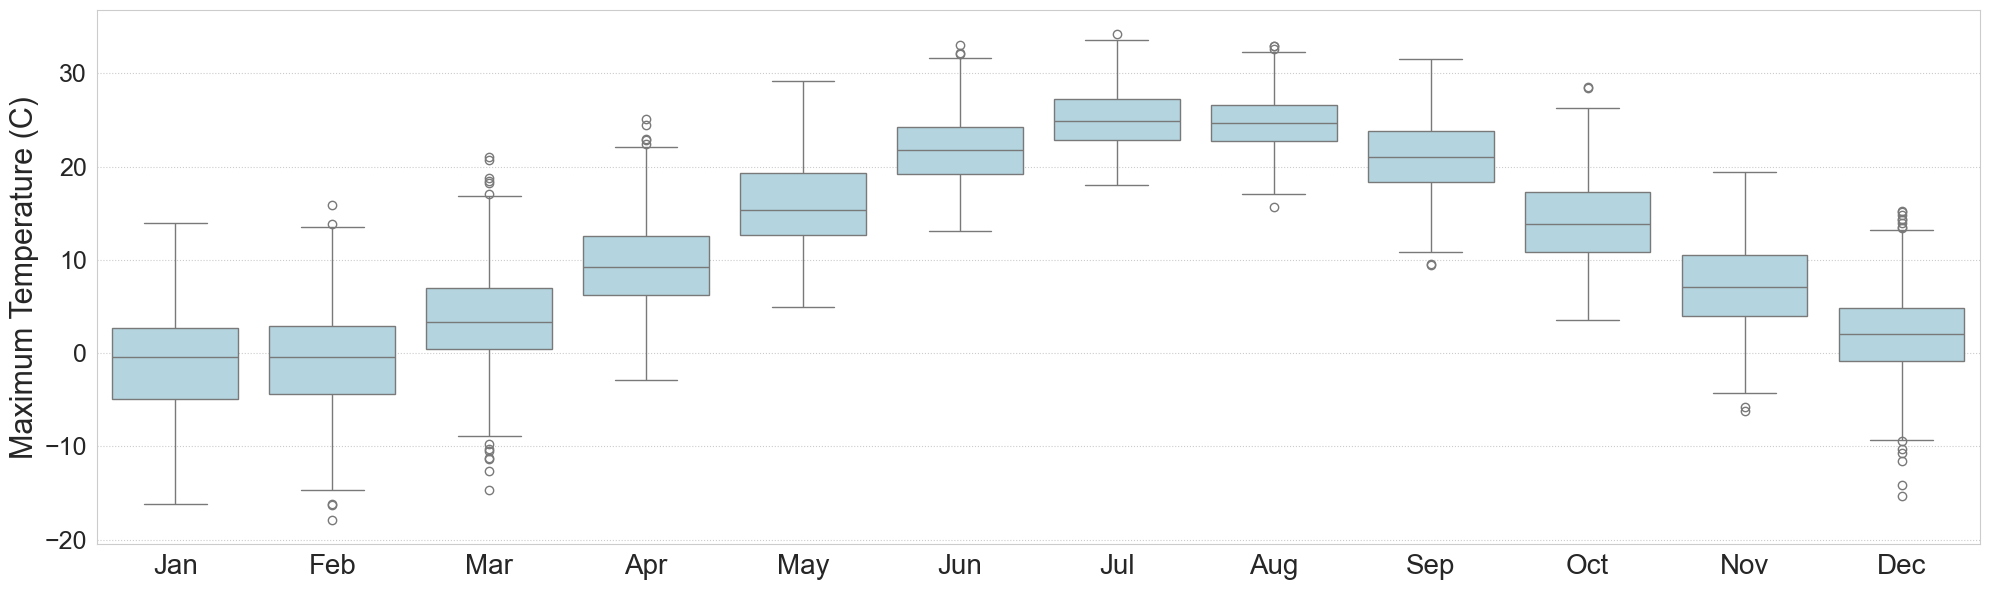

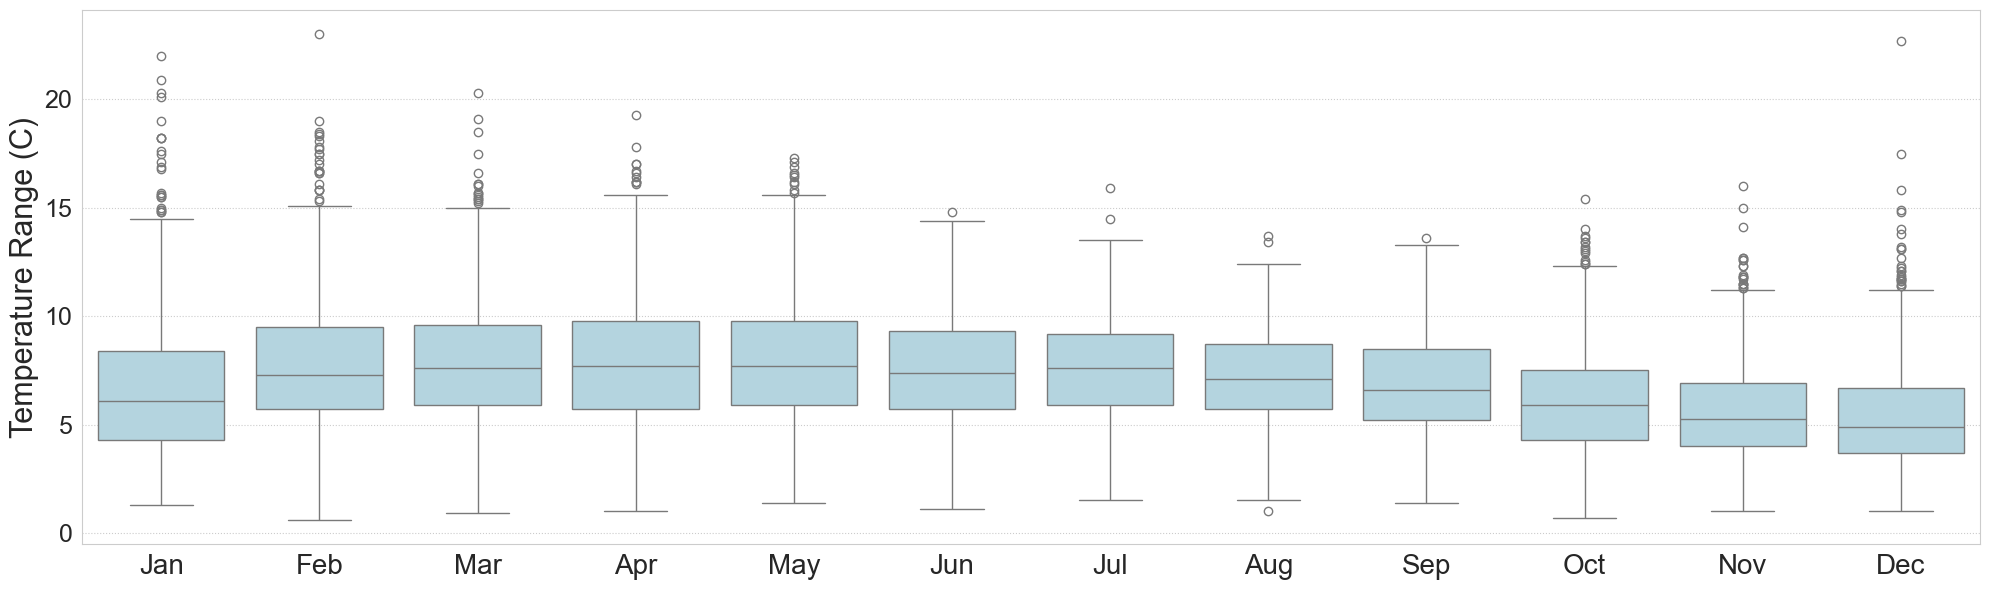

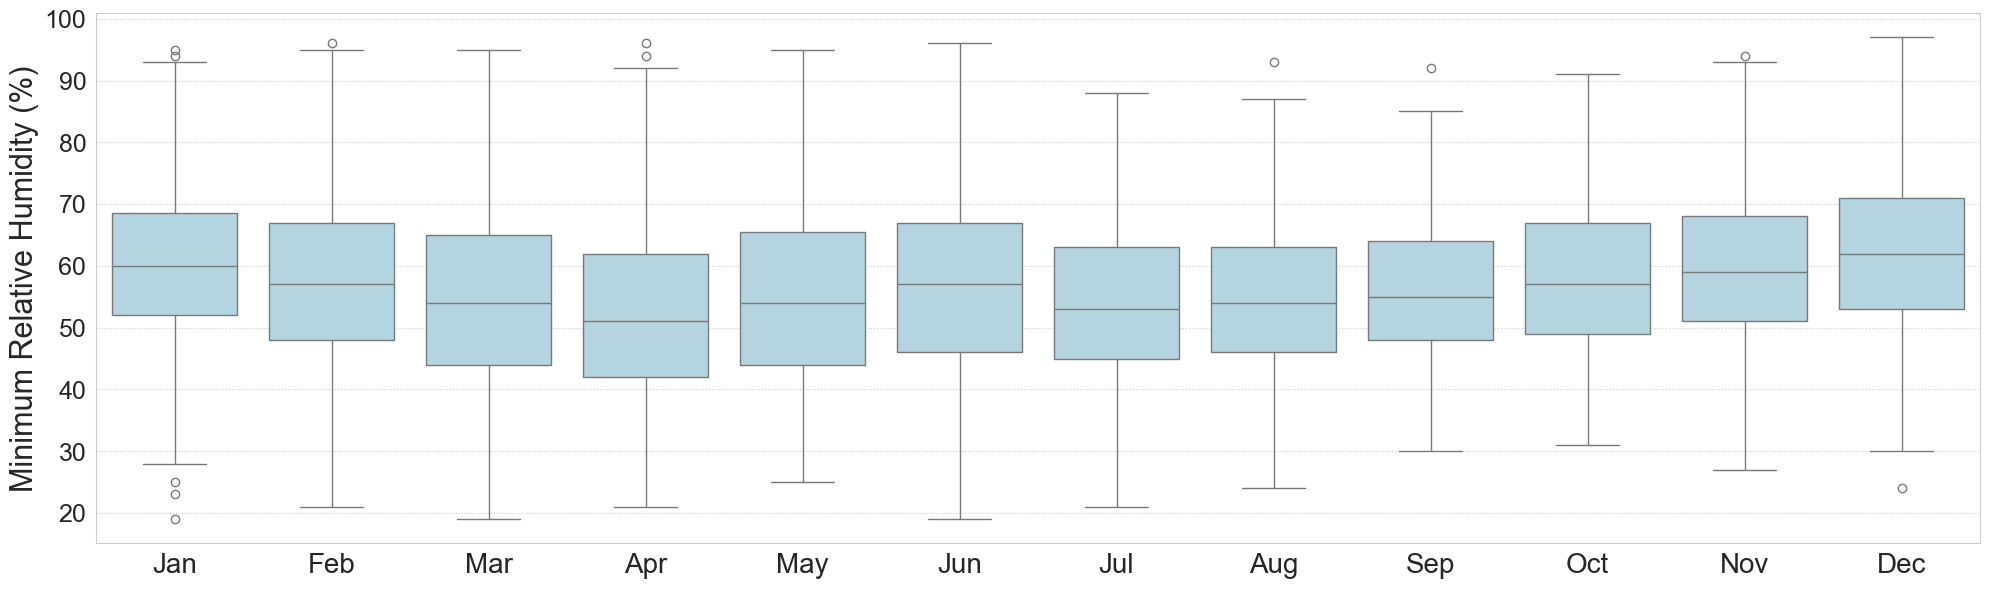

In [21]:
y_labels = {
    'sunshine_hr': 'Sunshine Duration (Hours)',
    'precipitation': 'Precipitation (mm)',
    'max_temp': 'Maximum Temperature (C)', 
    'temp_range': 'Temperature Range (C)',
    'min_humidity': 'Minimum Relative Humidity (%)',
    'mean_cloud_cover': 'Mean Total Cloud Cover (%)',
    'max_wind_speed': 'Maximum Wind Speed (km/h)'
}

# importlib.reload(vf) 
cols_to_plot = df_daily_subset.columns[:-7]
vf.generate_boxplots(data=df_daily_subset, columns=cols_to_plot, y_labels=y_labels,
                  alternate_x_labels=month_label_abbr, granularity='month', 
                    name='monthly_boxplots')

Rather than looking at global outliers, we first assess them using a monthly lens. Sunshine Duration has outliers that are primarily in the May to September period, with July and August having the majority of them. Precipitation, on the other hand, has outliers dispersed throughout the months of the year, as do Maximum Wind Speed and Temperature Range. Mean Cloud Cover and Minimum Humidity have the fewest outliers, with the former only having three impacted months. 

We will adjust the outlier values in each column by capping them at +/- 1.5 * IQR (i.e. the limits beyond which a data point is generally considered to be an outlier). We do this to ensure that they do not derail our machine learning models during our experiments. 

In [24]:
df_clean = pf.adjust_outliers(df_daily_subset, columns=cols_to_plot, granularity='month')

Total outliers adjusted in the sunshine_hr column: 379
Percent of total rows: 3.58%


Total outliers adjusted in the precipitation column: 1,528
Percent of total rows: 14.43%


Total outliers adjusted in the max_temp column: 51
Percent of total rows: 0.48%


Total outliers adjusted in the temp_range column: 149
Percent of total rows: 1.41%


Total outliers adjusted in the min_humidity column: 12
Percent of total rows: 0.11%




We review the boxplots anew:

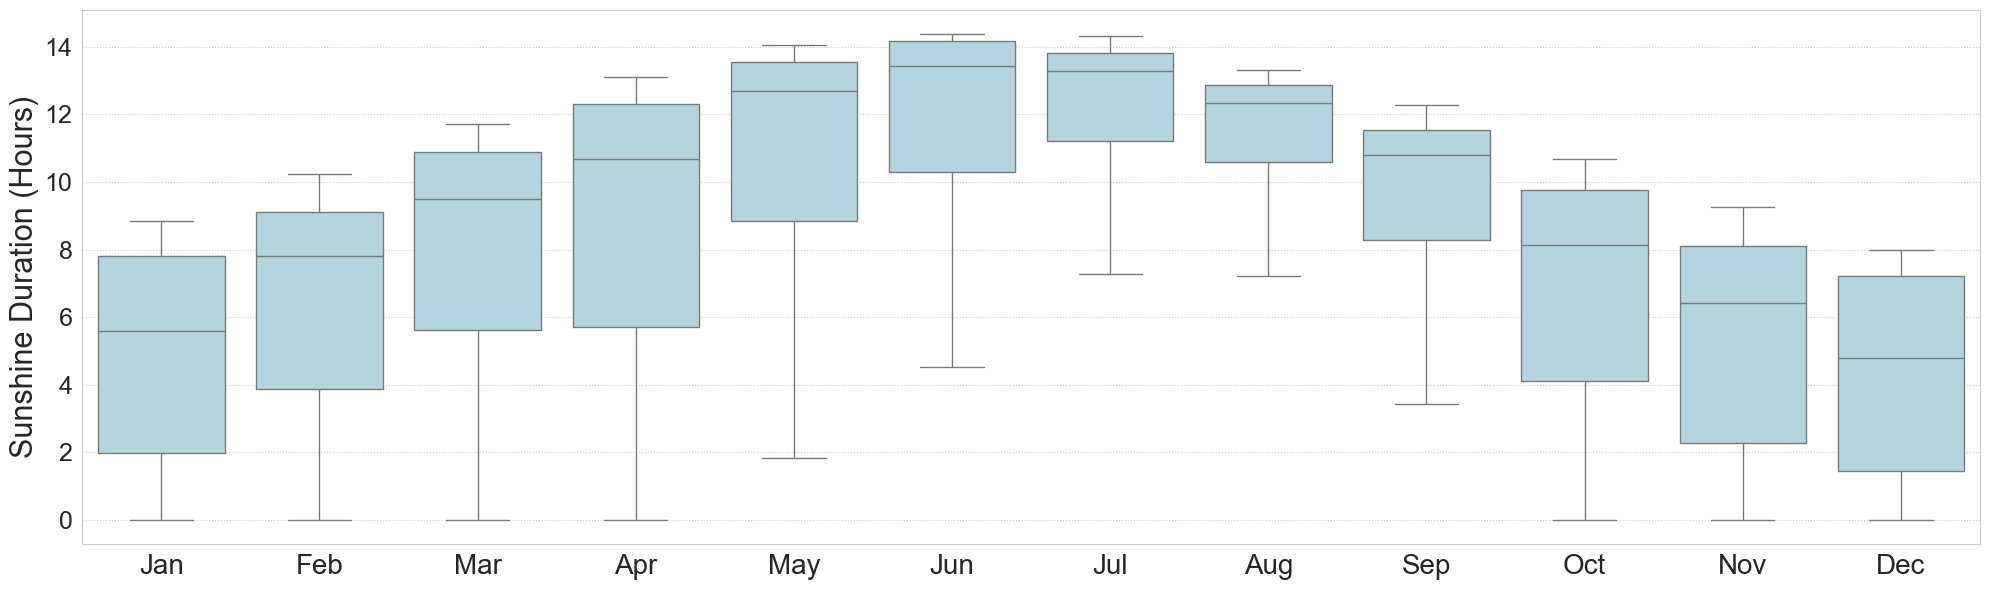

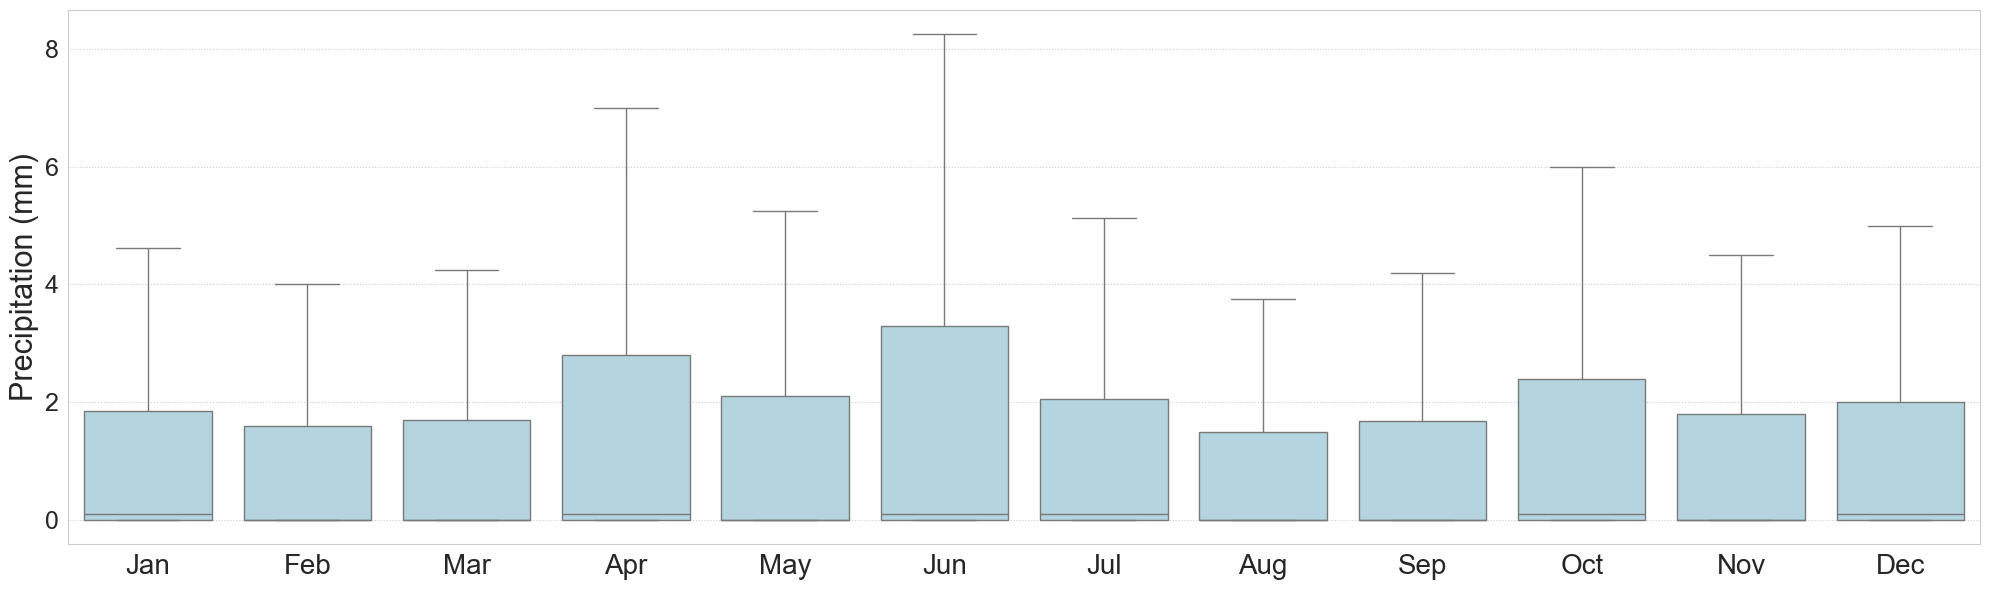

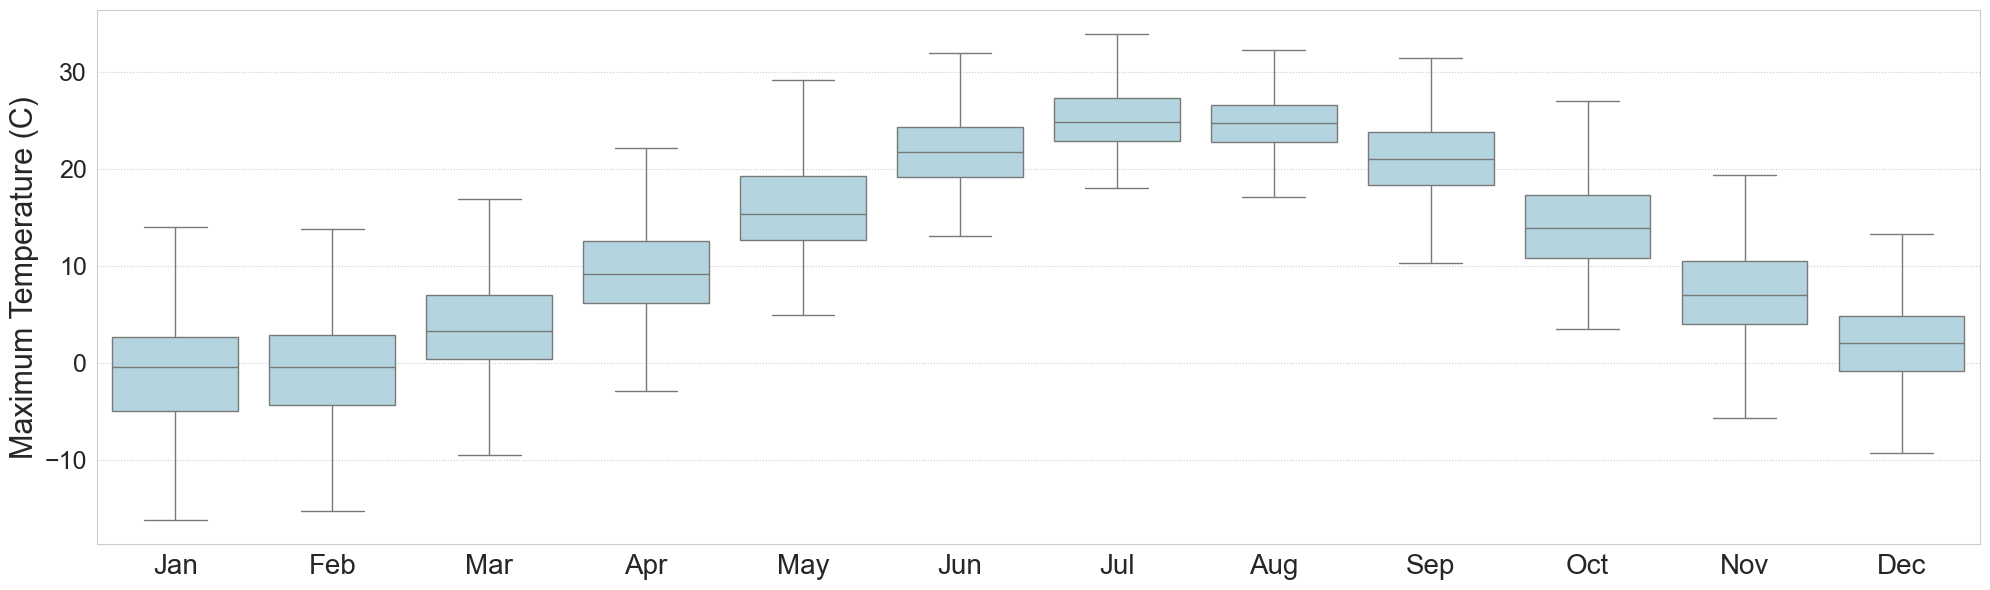

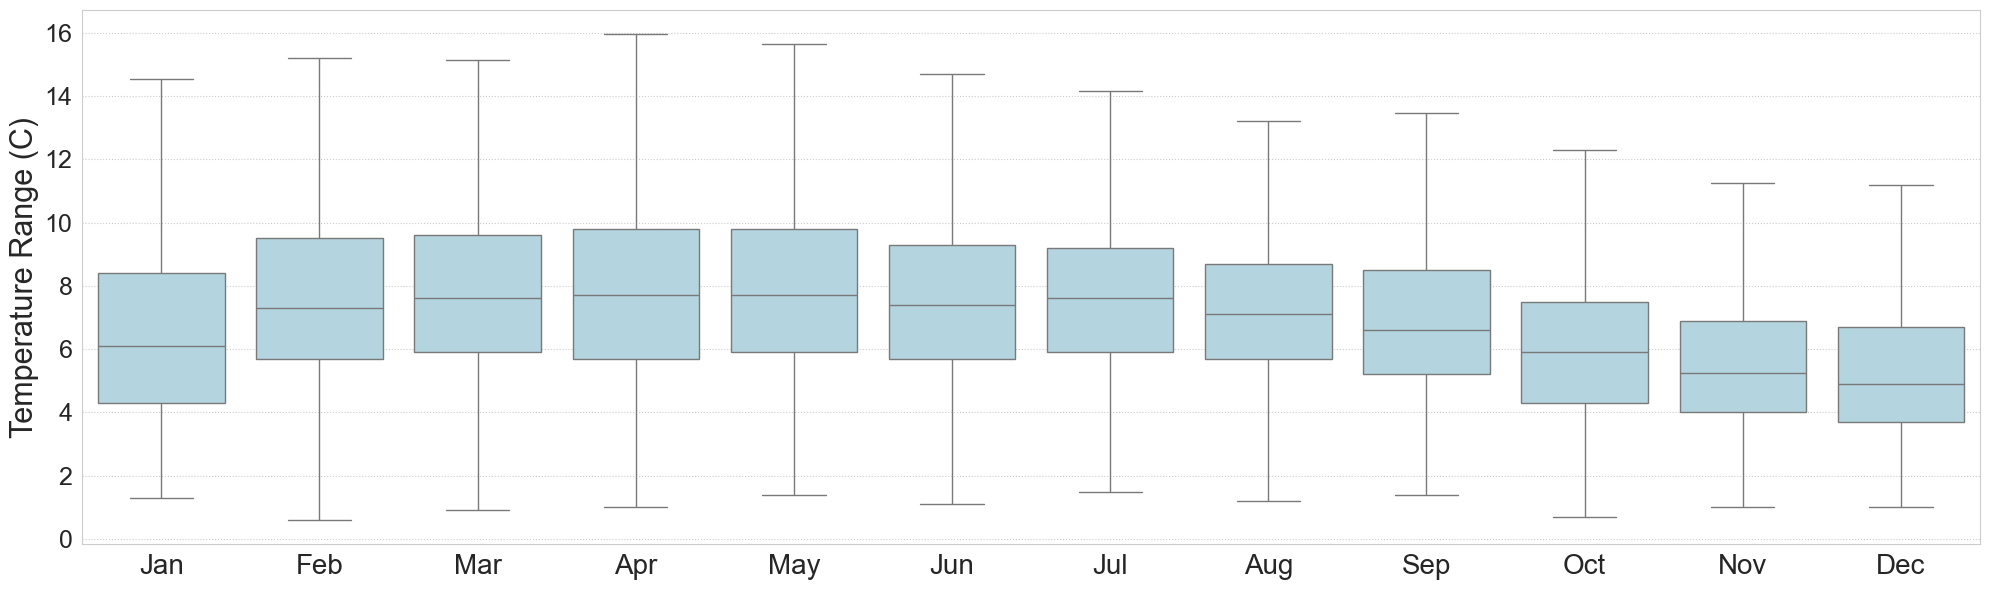

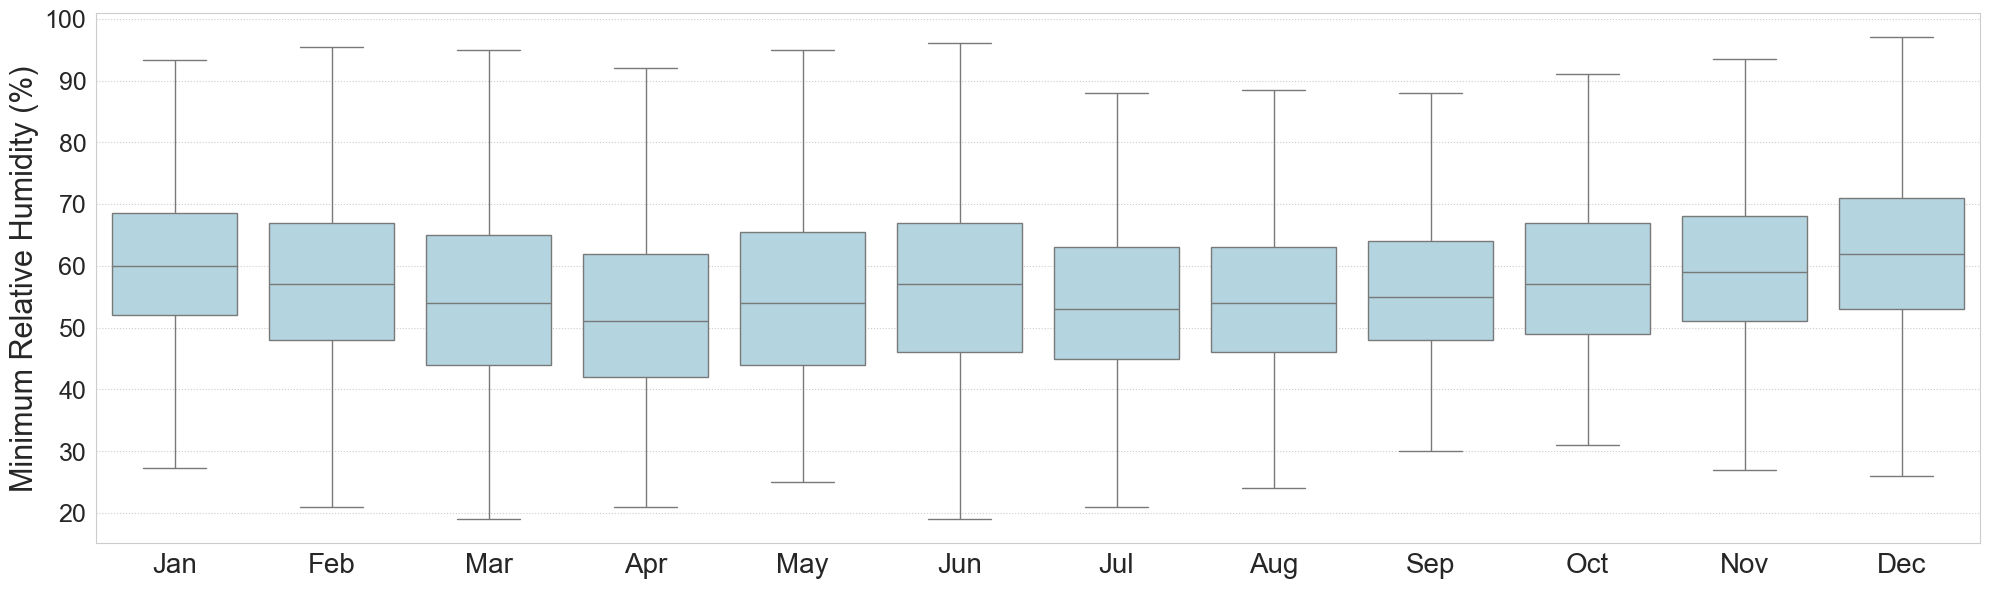

In [25]:
# importlib.reload(vf) 
vf.generate_boxplots(data=df_clean, columns=cols_to_plot, y_labels=y_labels,
                  alternate_x_labels=month_label_abbr, granularity='month', 
                    name='monthly_boxplots_clean')

Having validated the expected results, we now turn our attention to the seasonal boxplots:

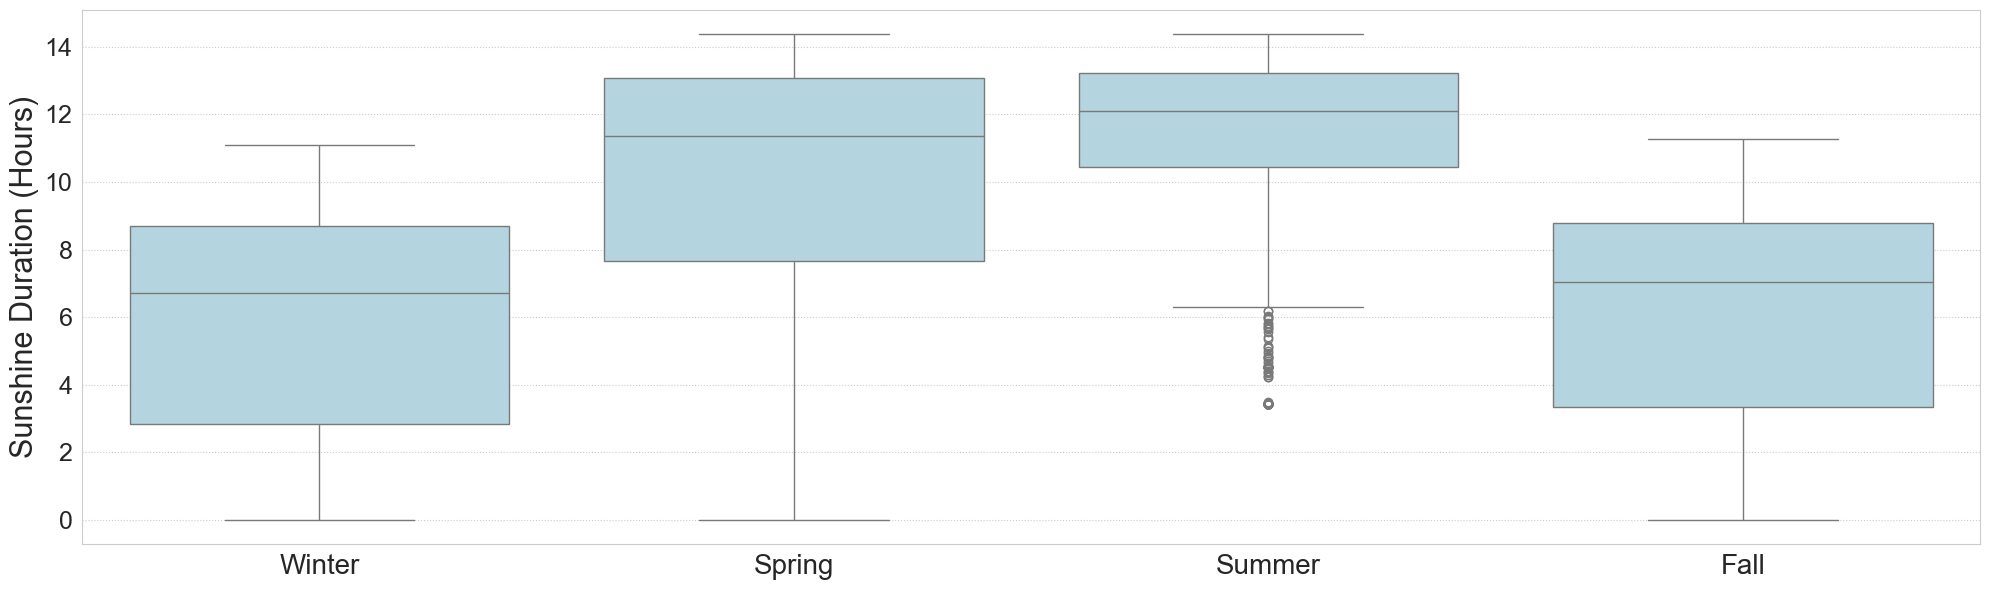

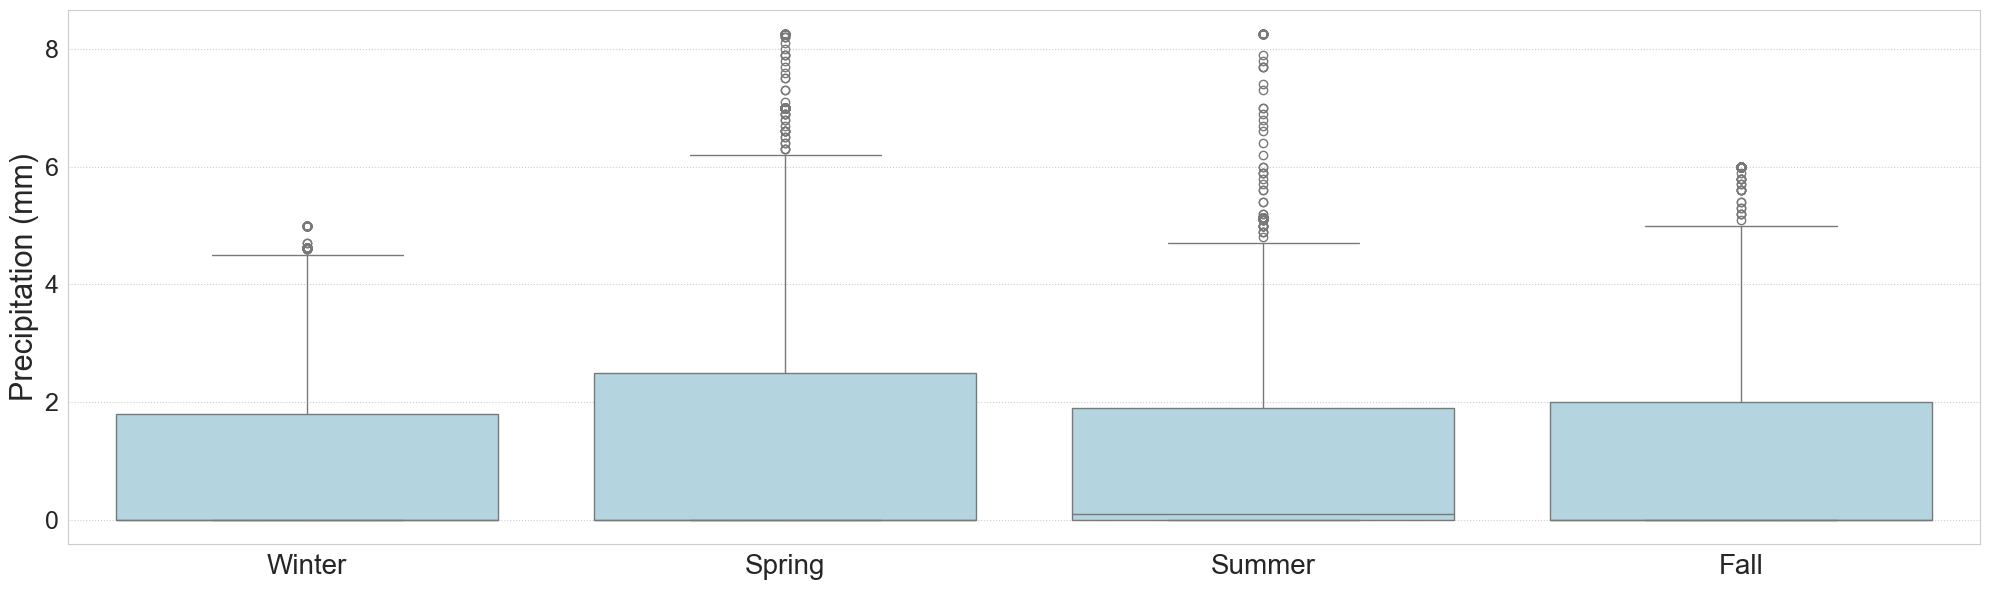

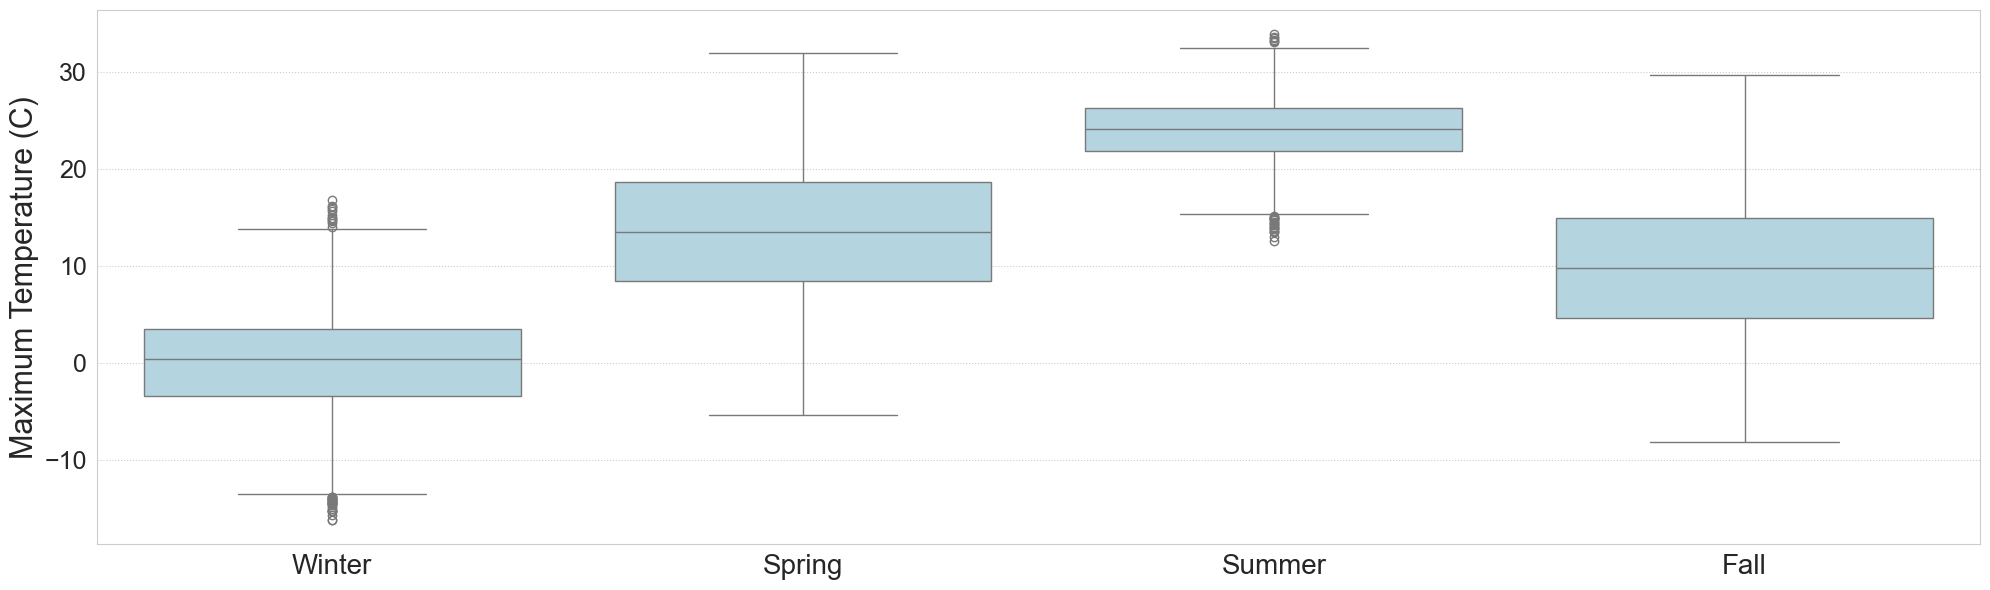

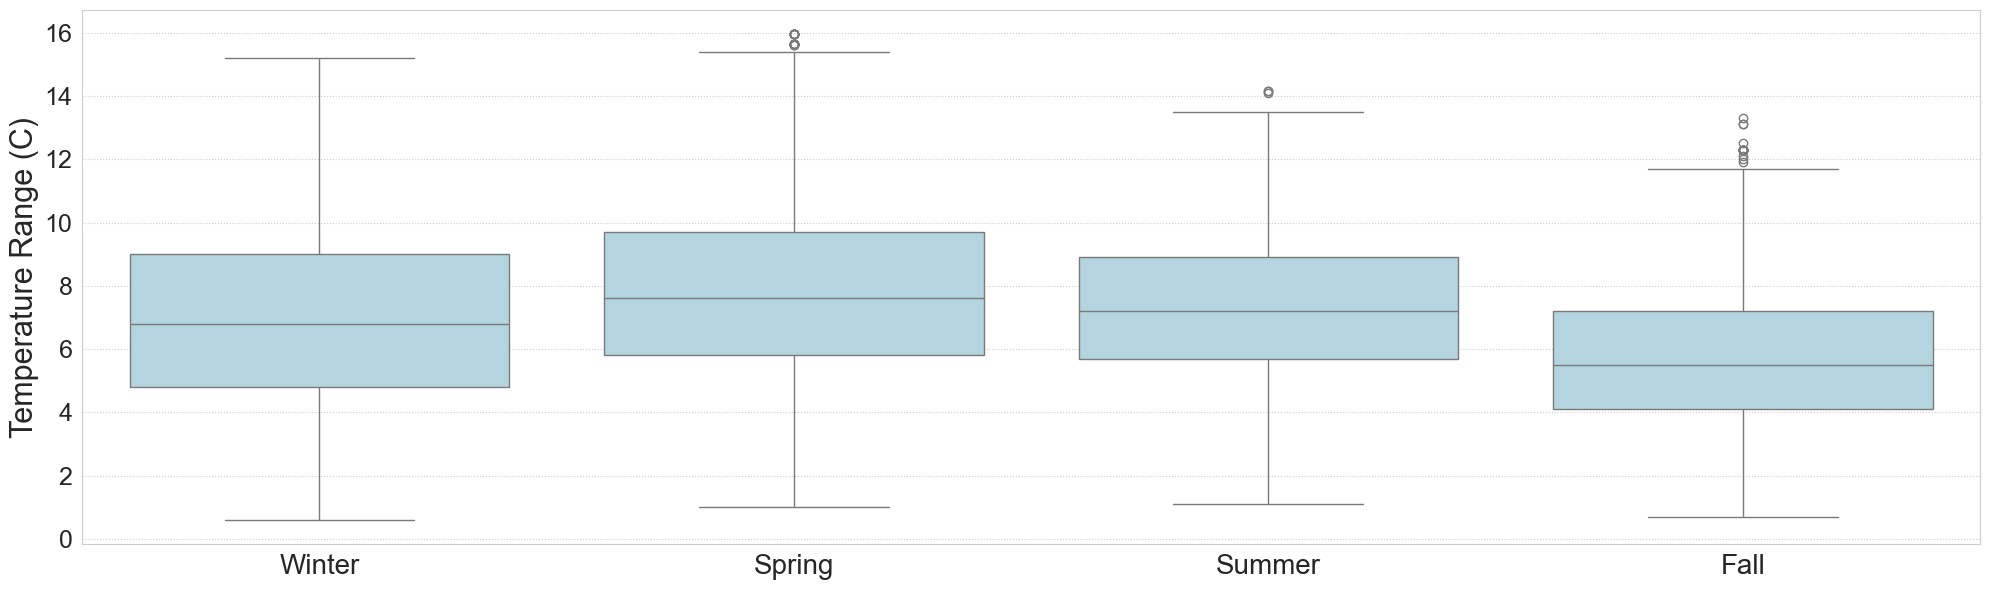

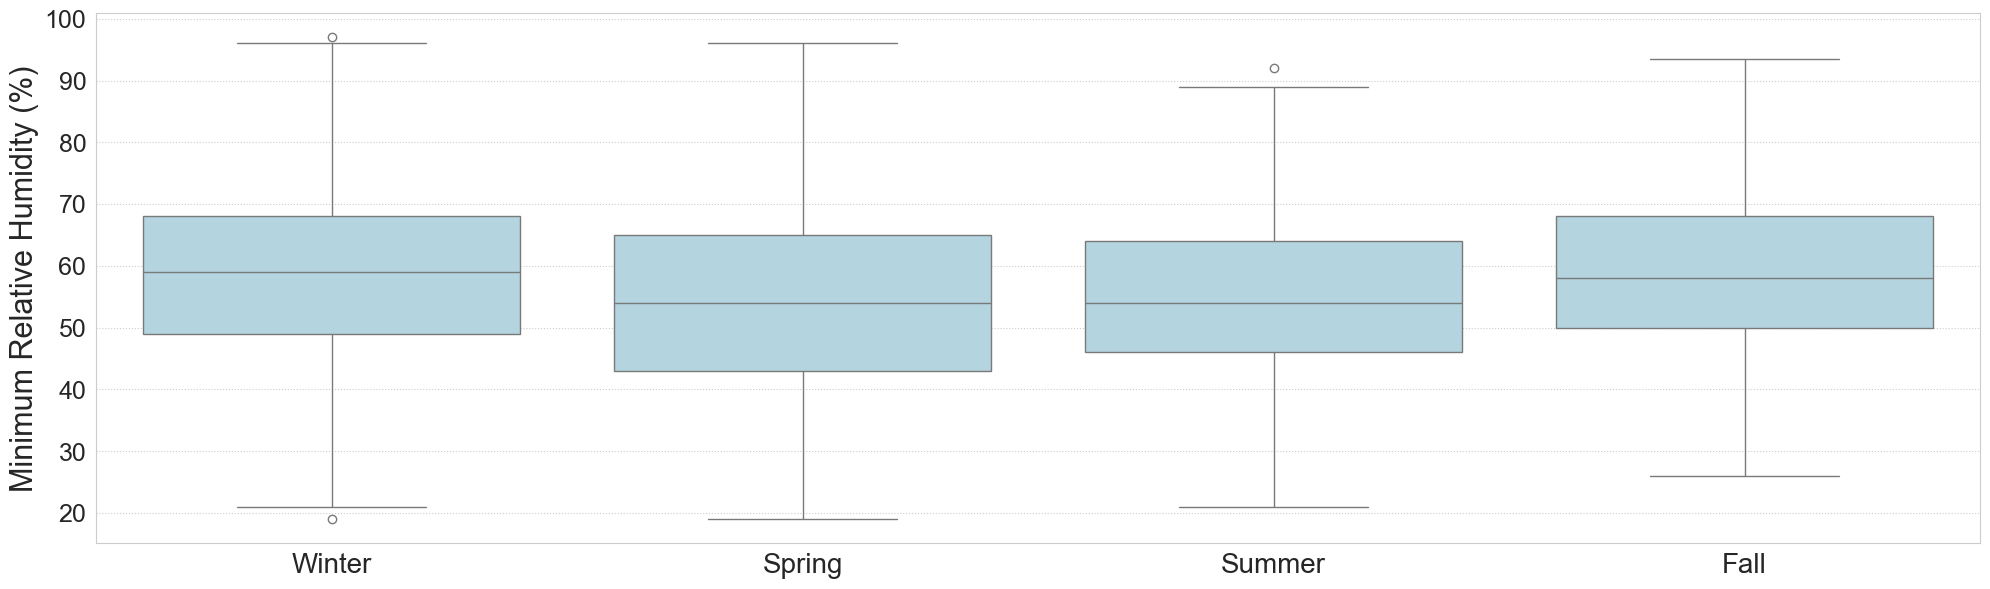

In [26]:
vf.generate_boxplots(data=df_clean, columns=cols_to_plot, y_labels=y_labels,
                  alternate_x_labels=None, granularity='season', name='seasonal_boxplots')

We can see than we are left with some outliers at the seasonal level, and we will handle them in the same way that we did the monthly ones.

Total outliers adjusted in the sunshine_hr column: 112
Percent of total rows: 1.06%


Total outliers adjusted in the precipitation column: 737
Percent of total rows: 6.96%


Total outliers adjusted in the max_temp column: 66
Percent of total rows: 0.62%


Total outliers adjusted in the temp_range column: 49
Percent of total rows: 0.46%


Total outliers adjusted in the min_humidity column: 3
Percent of total rows: 0.03%




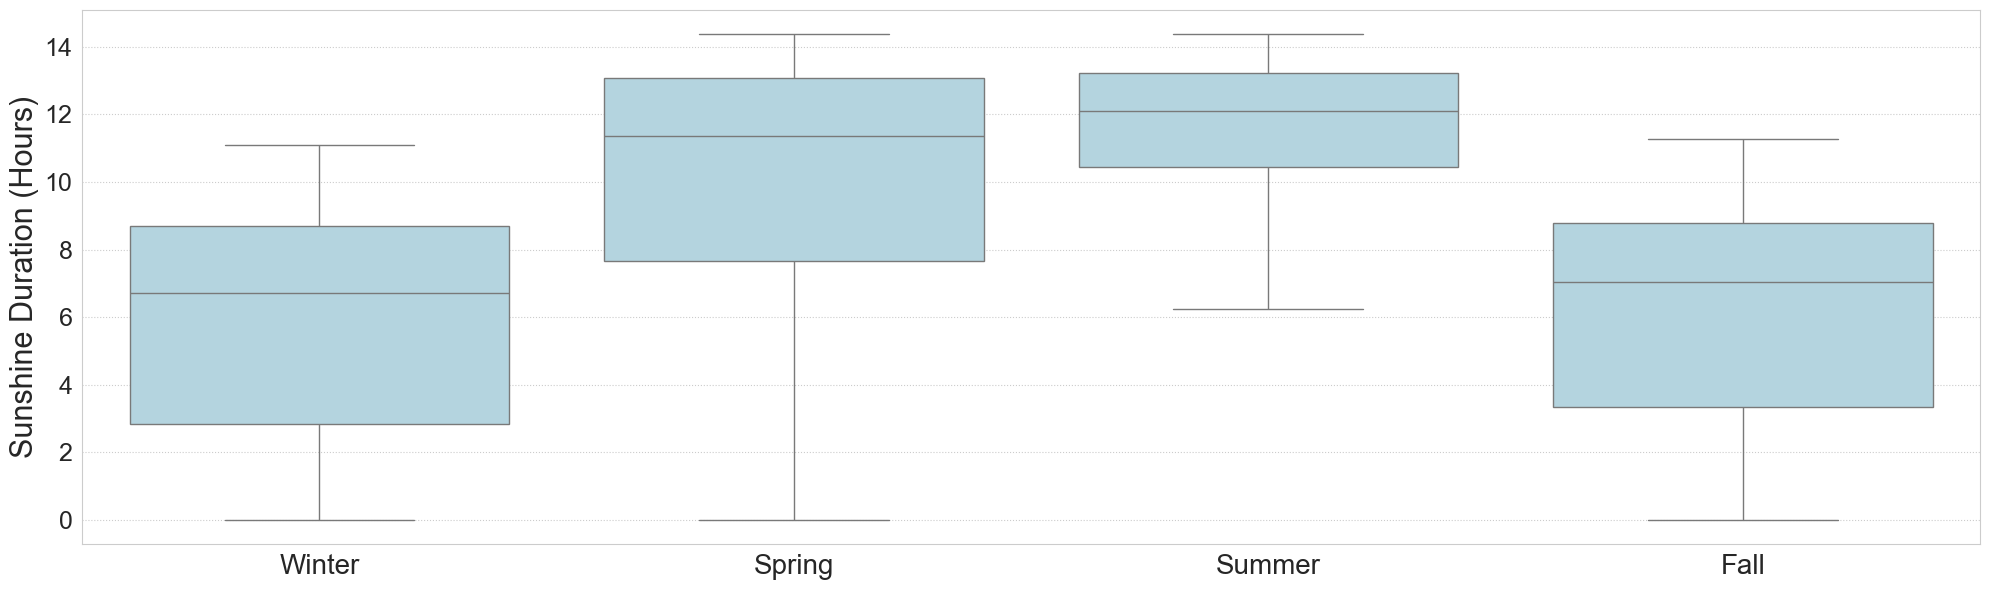

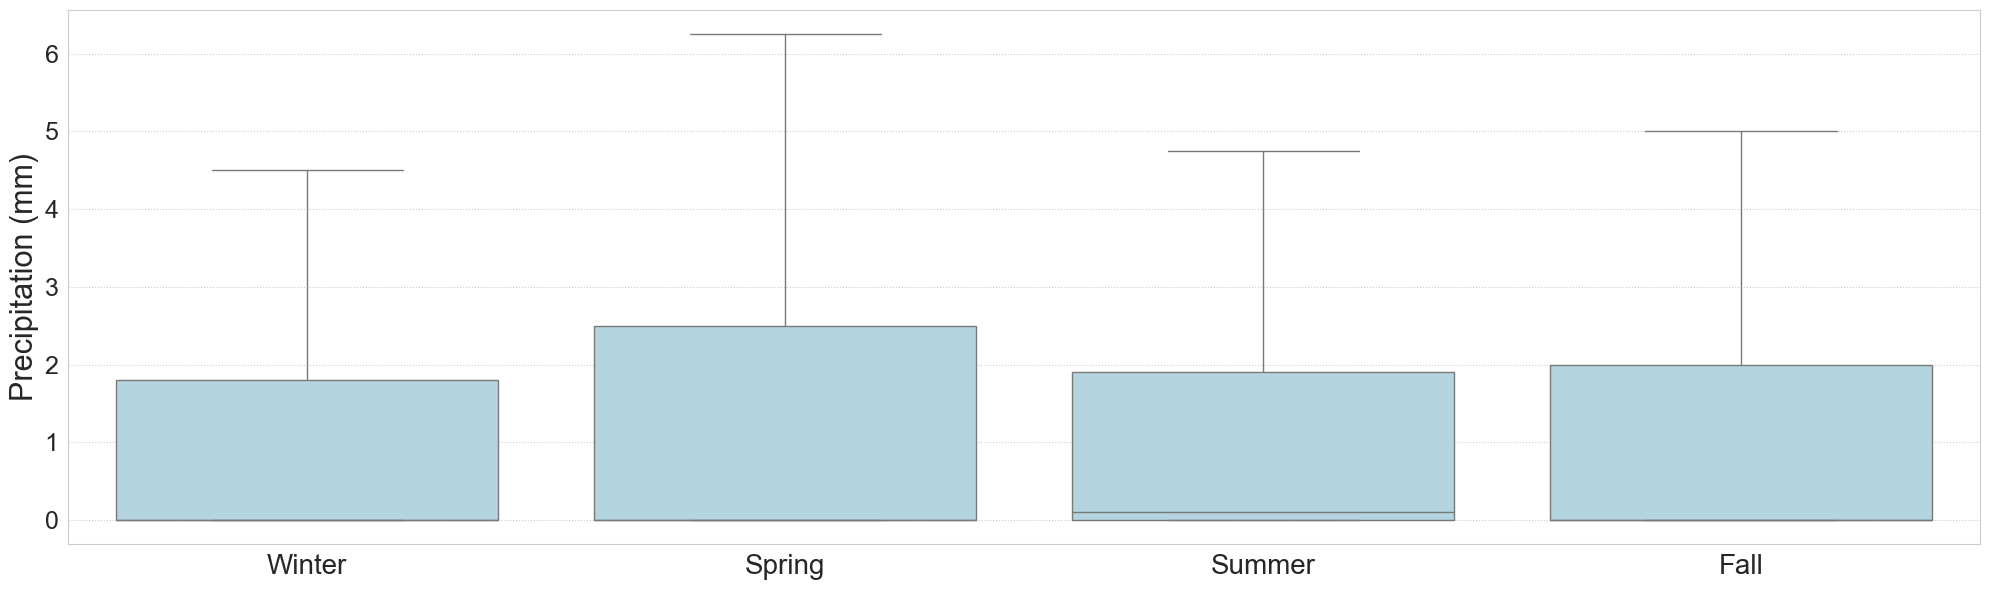

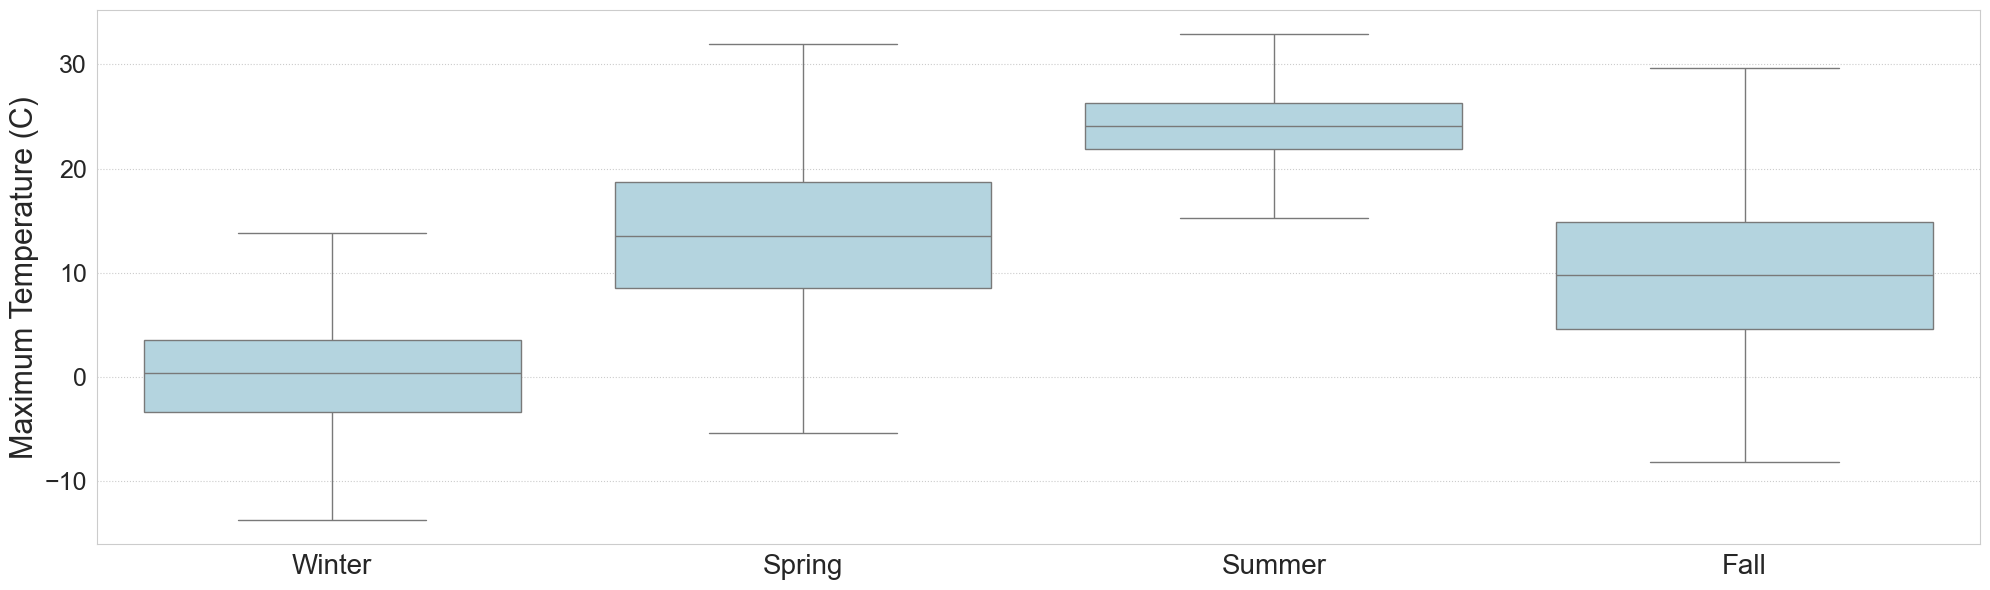

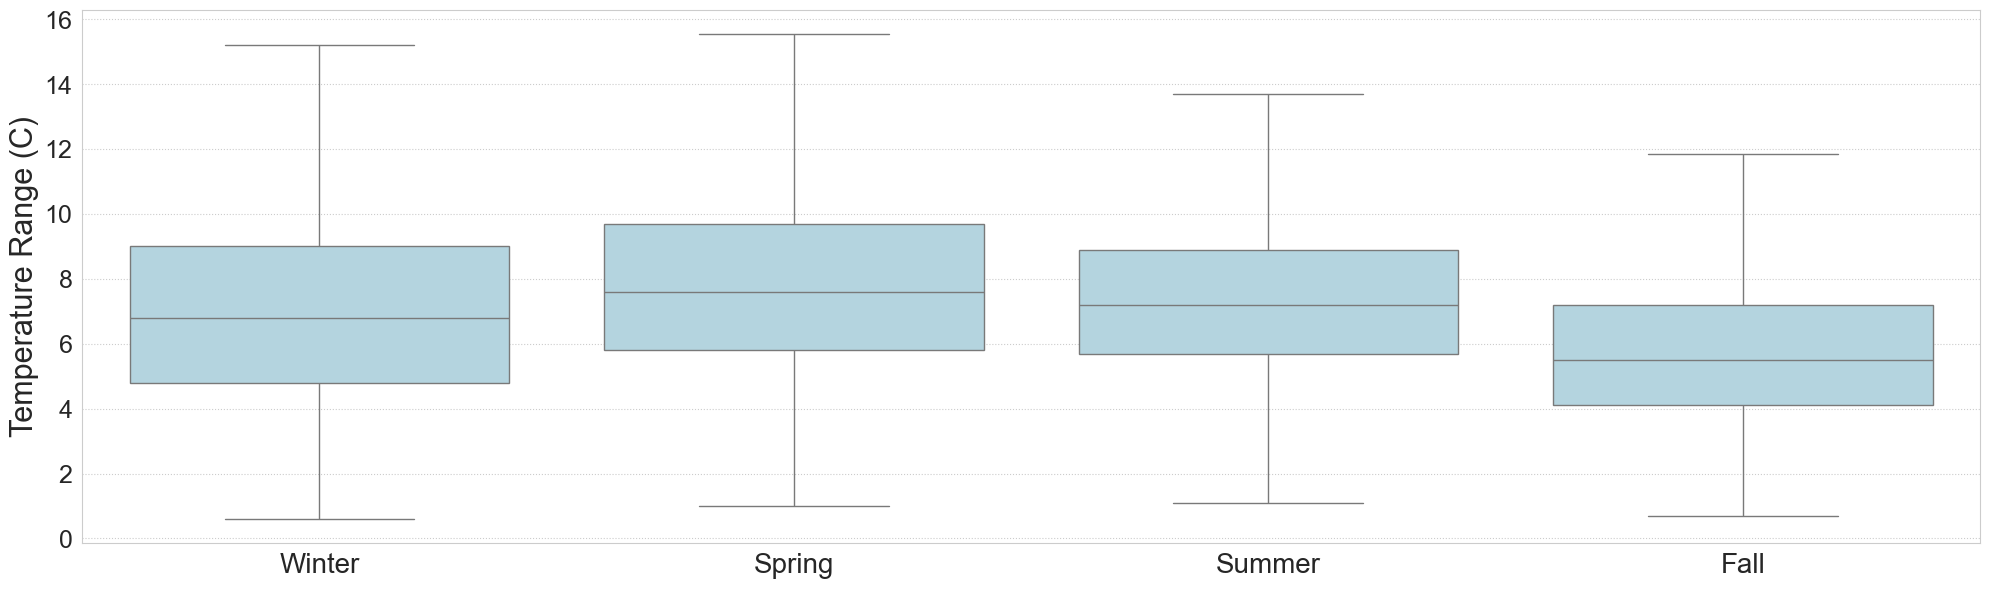

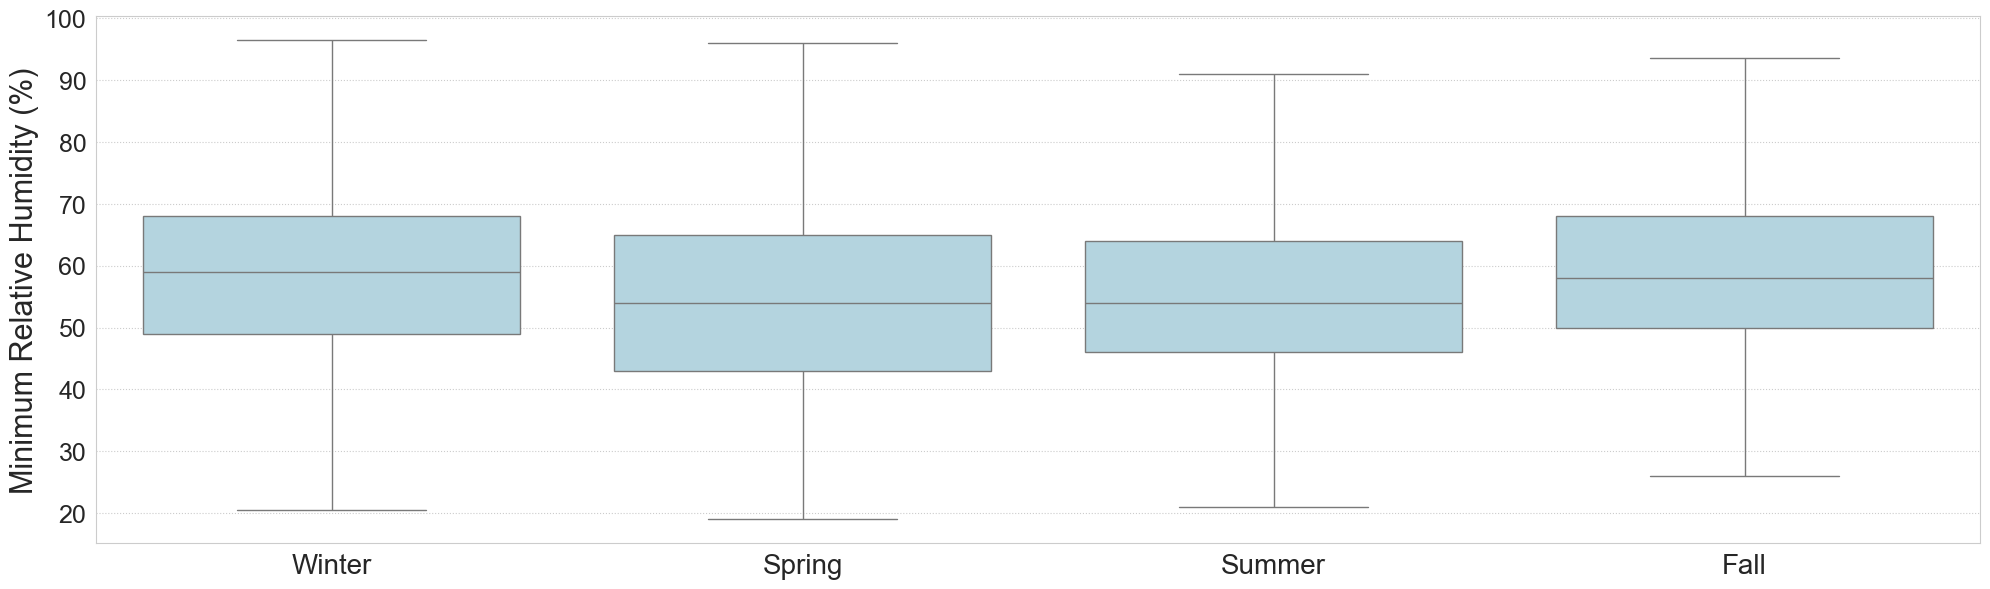

In [28]:
df_clean = pf.adjust_outliers(df_clean, columns=cols_to_plot, granularity='season')

vf.generate_boxplots(data=df_clean, columns=cols_to_plot, y_labels=y_labels,
                  alternate_x_labels=None, granularity='season', 
                     name='seasonal_boxplots_clean')

Now that we have a clean dataset, we can save it and move on to our experiments.

In [29]:
df_clean.to_csv('weather_data_clean.csv')